-----------------------------------


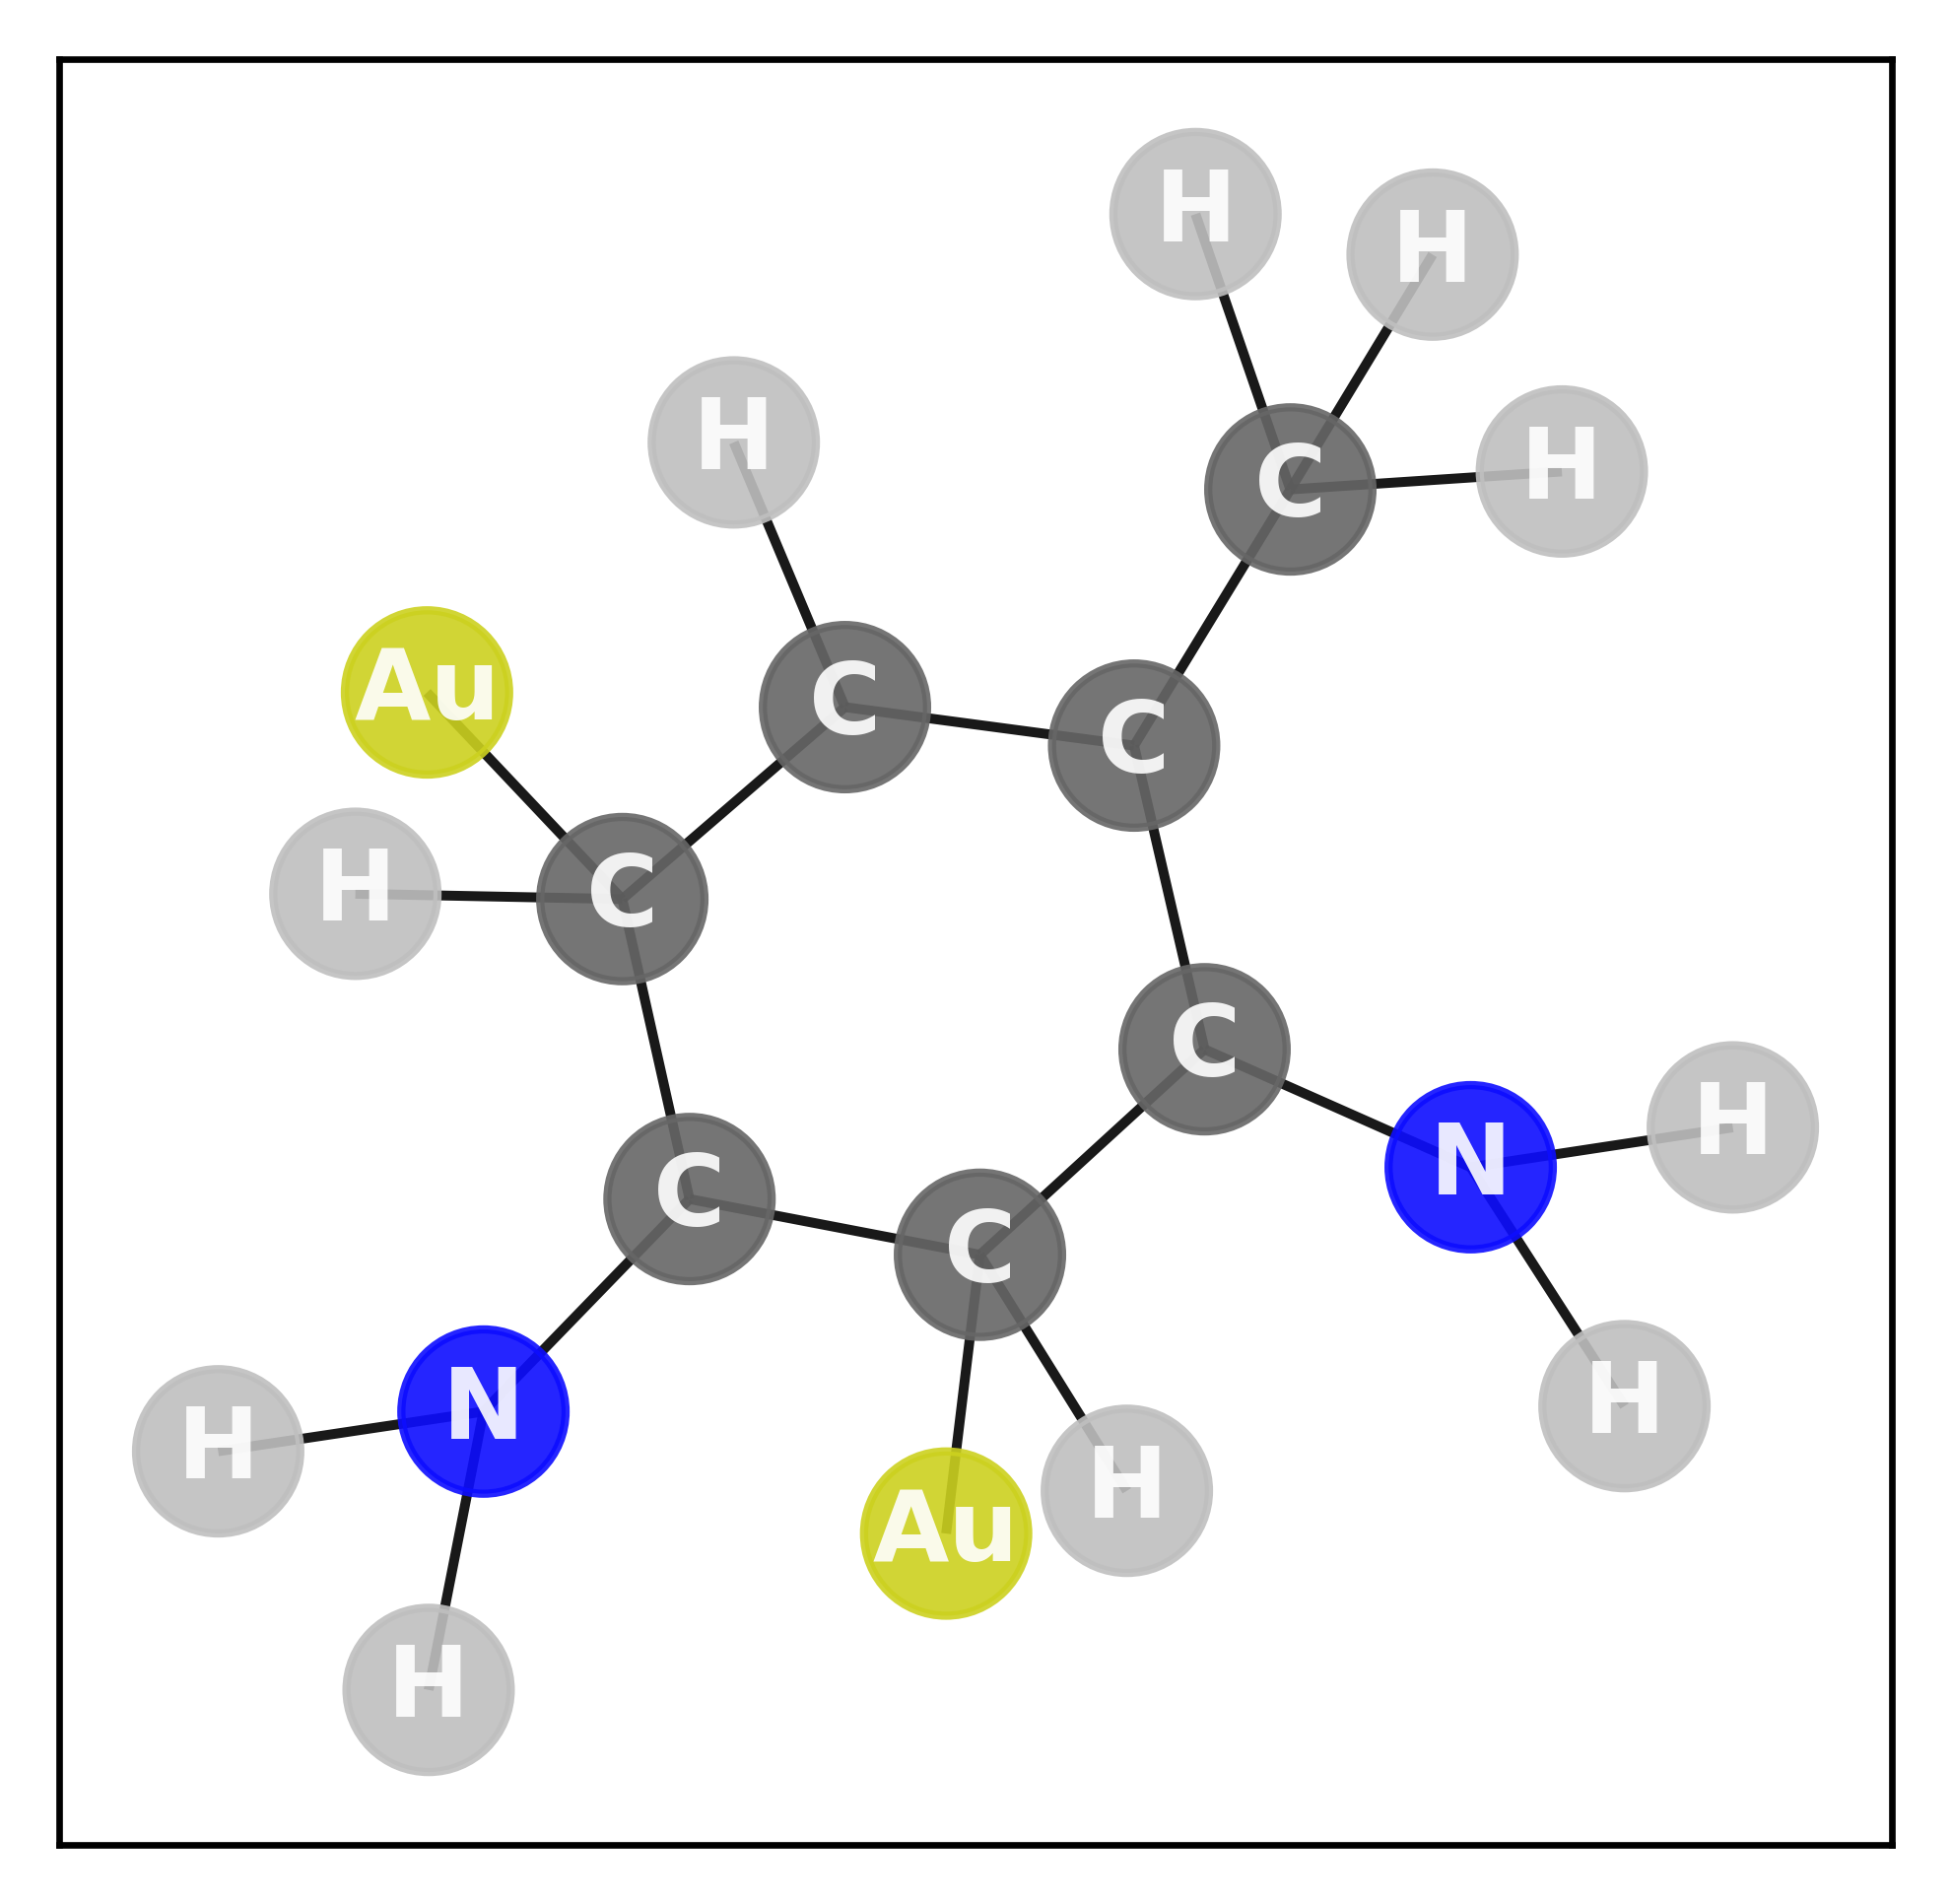

System: au-mol_16
GNN energy = -118.53 eV 
VASP energy = -117.80113190000009 eV
Prediction error = 0.73 eV
-----------------------------------


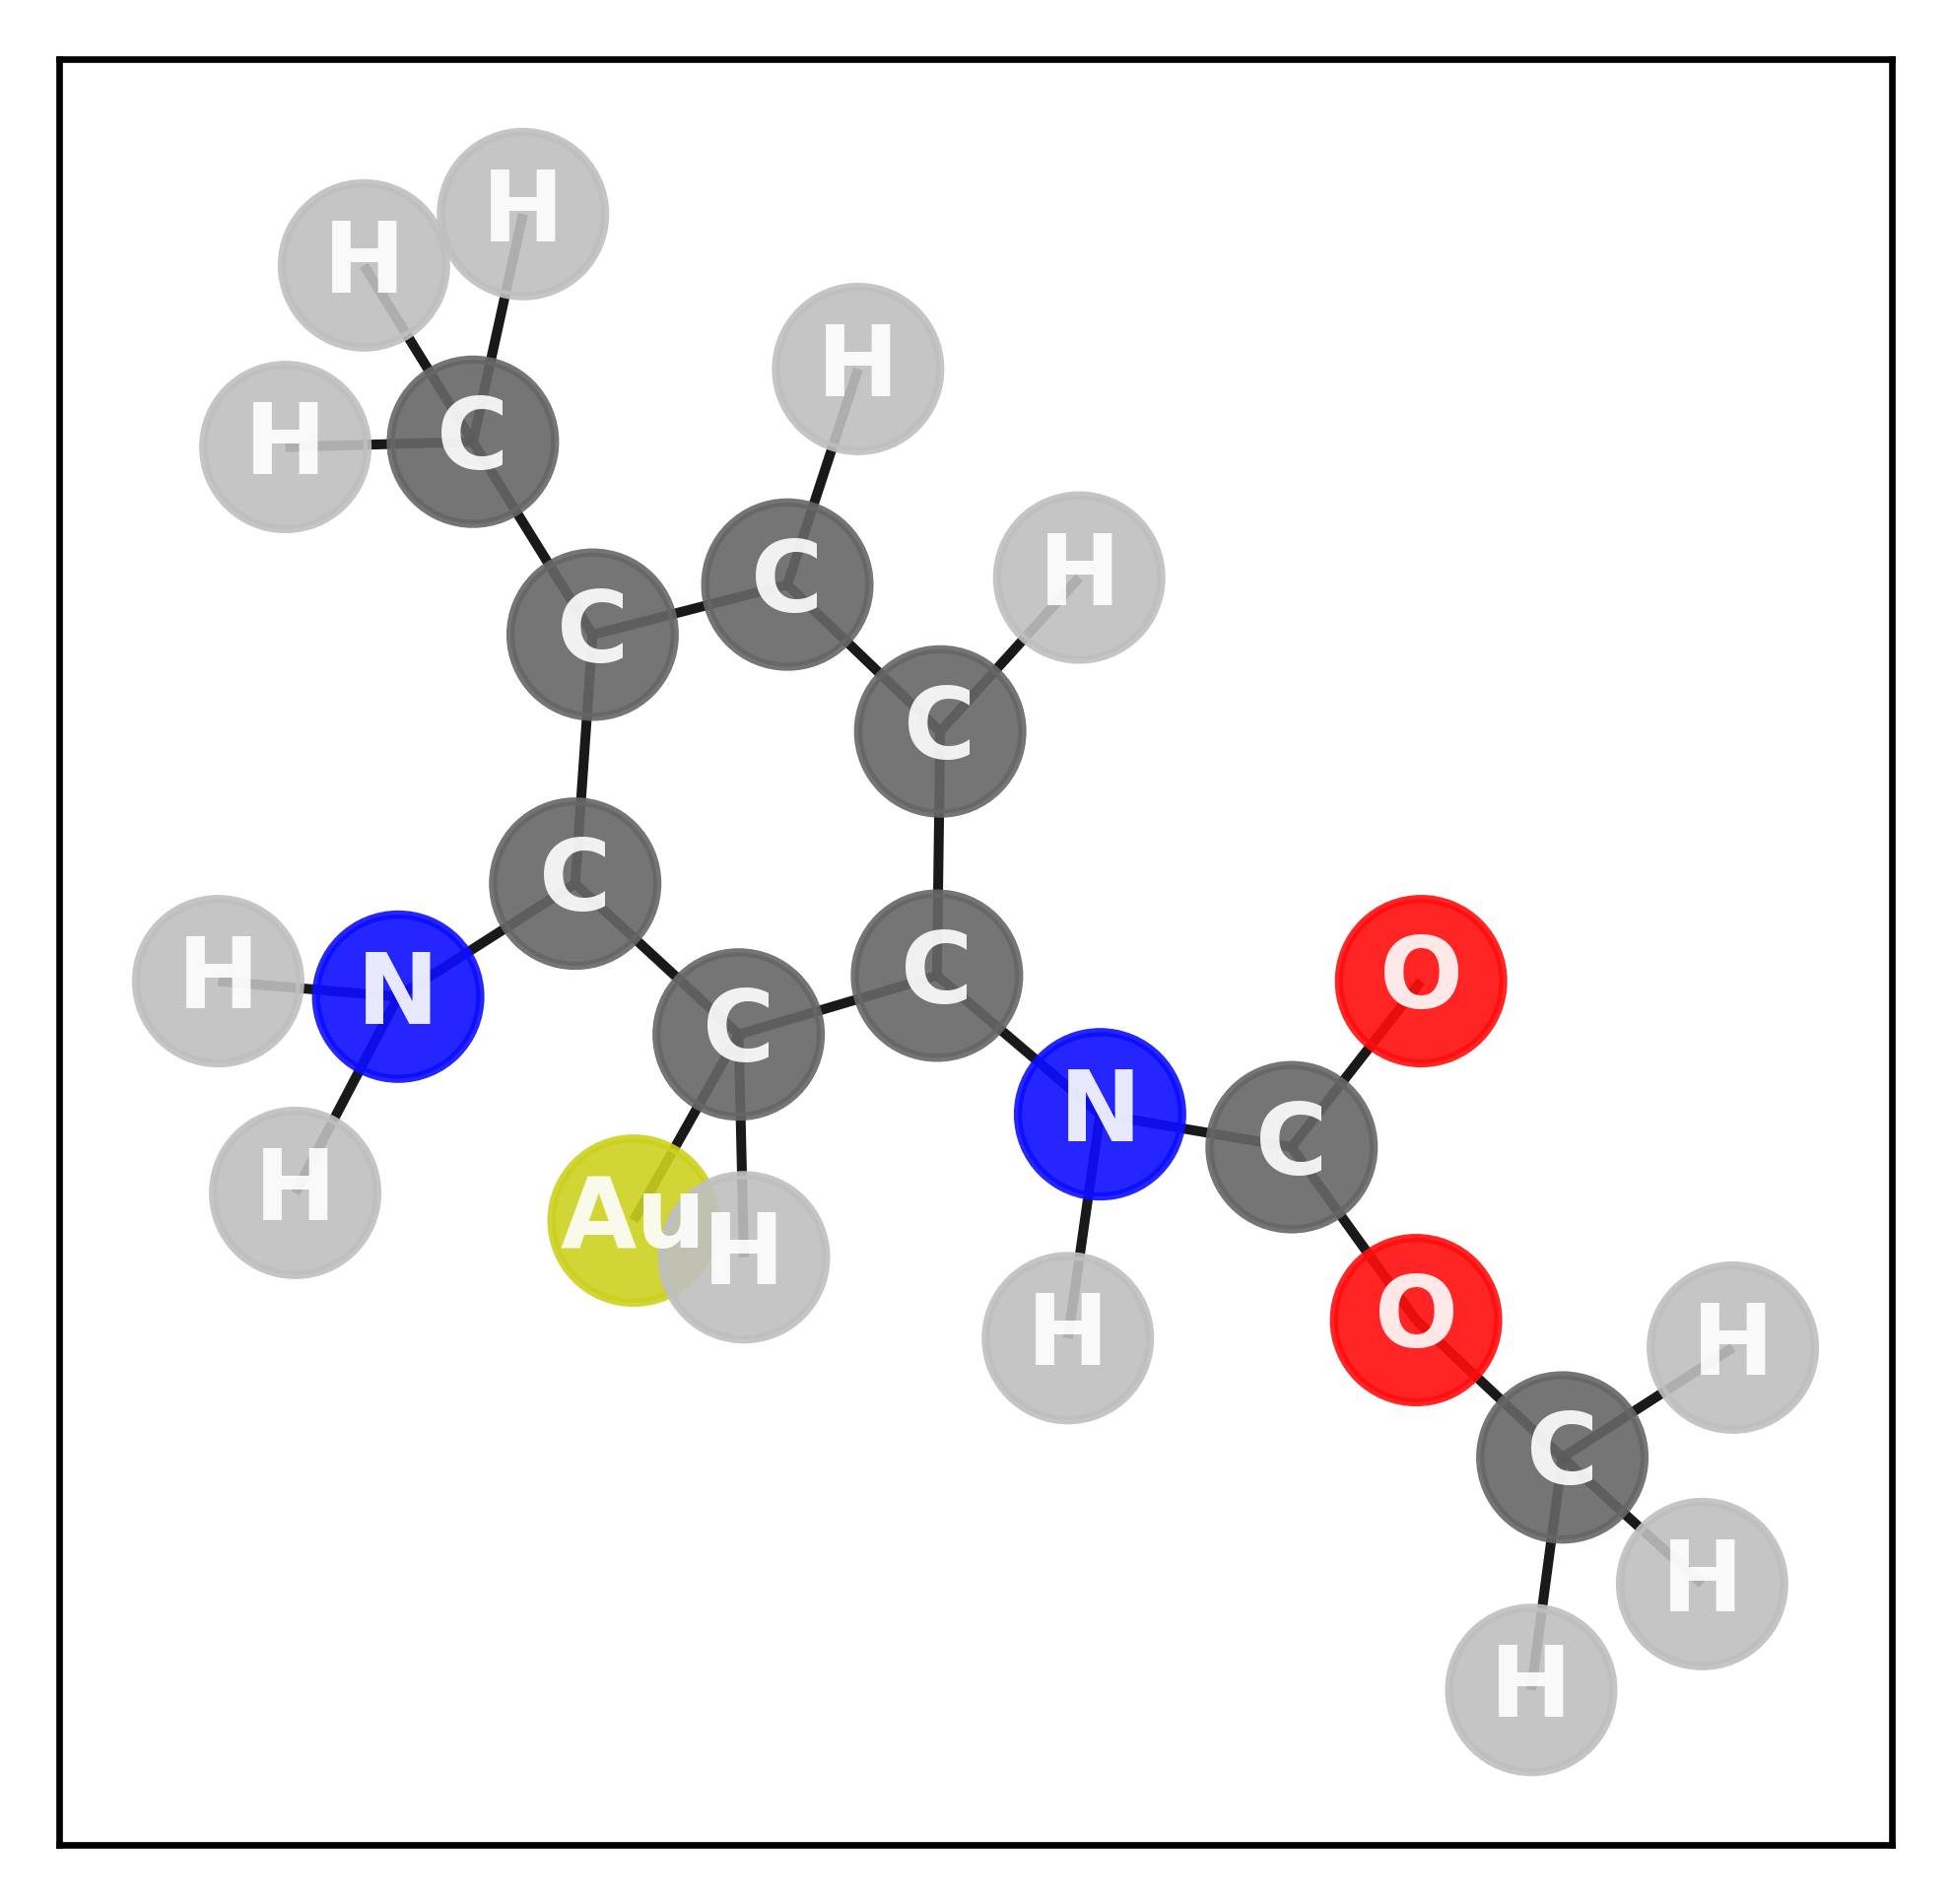

System: au-mol_17
GNN energy = -158.28 eV 
VASP energy = -157.0177393900001 eV
Prediction error = 1.26 eV
-----------------------------------


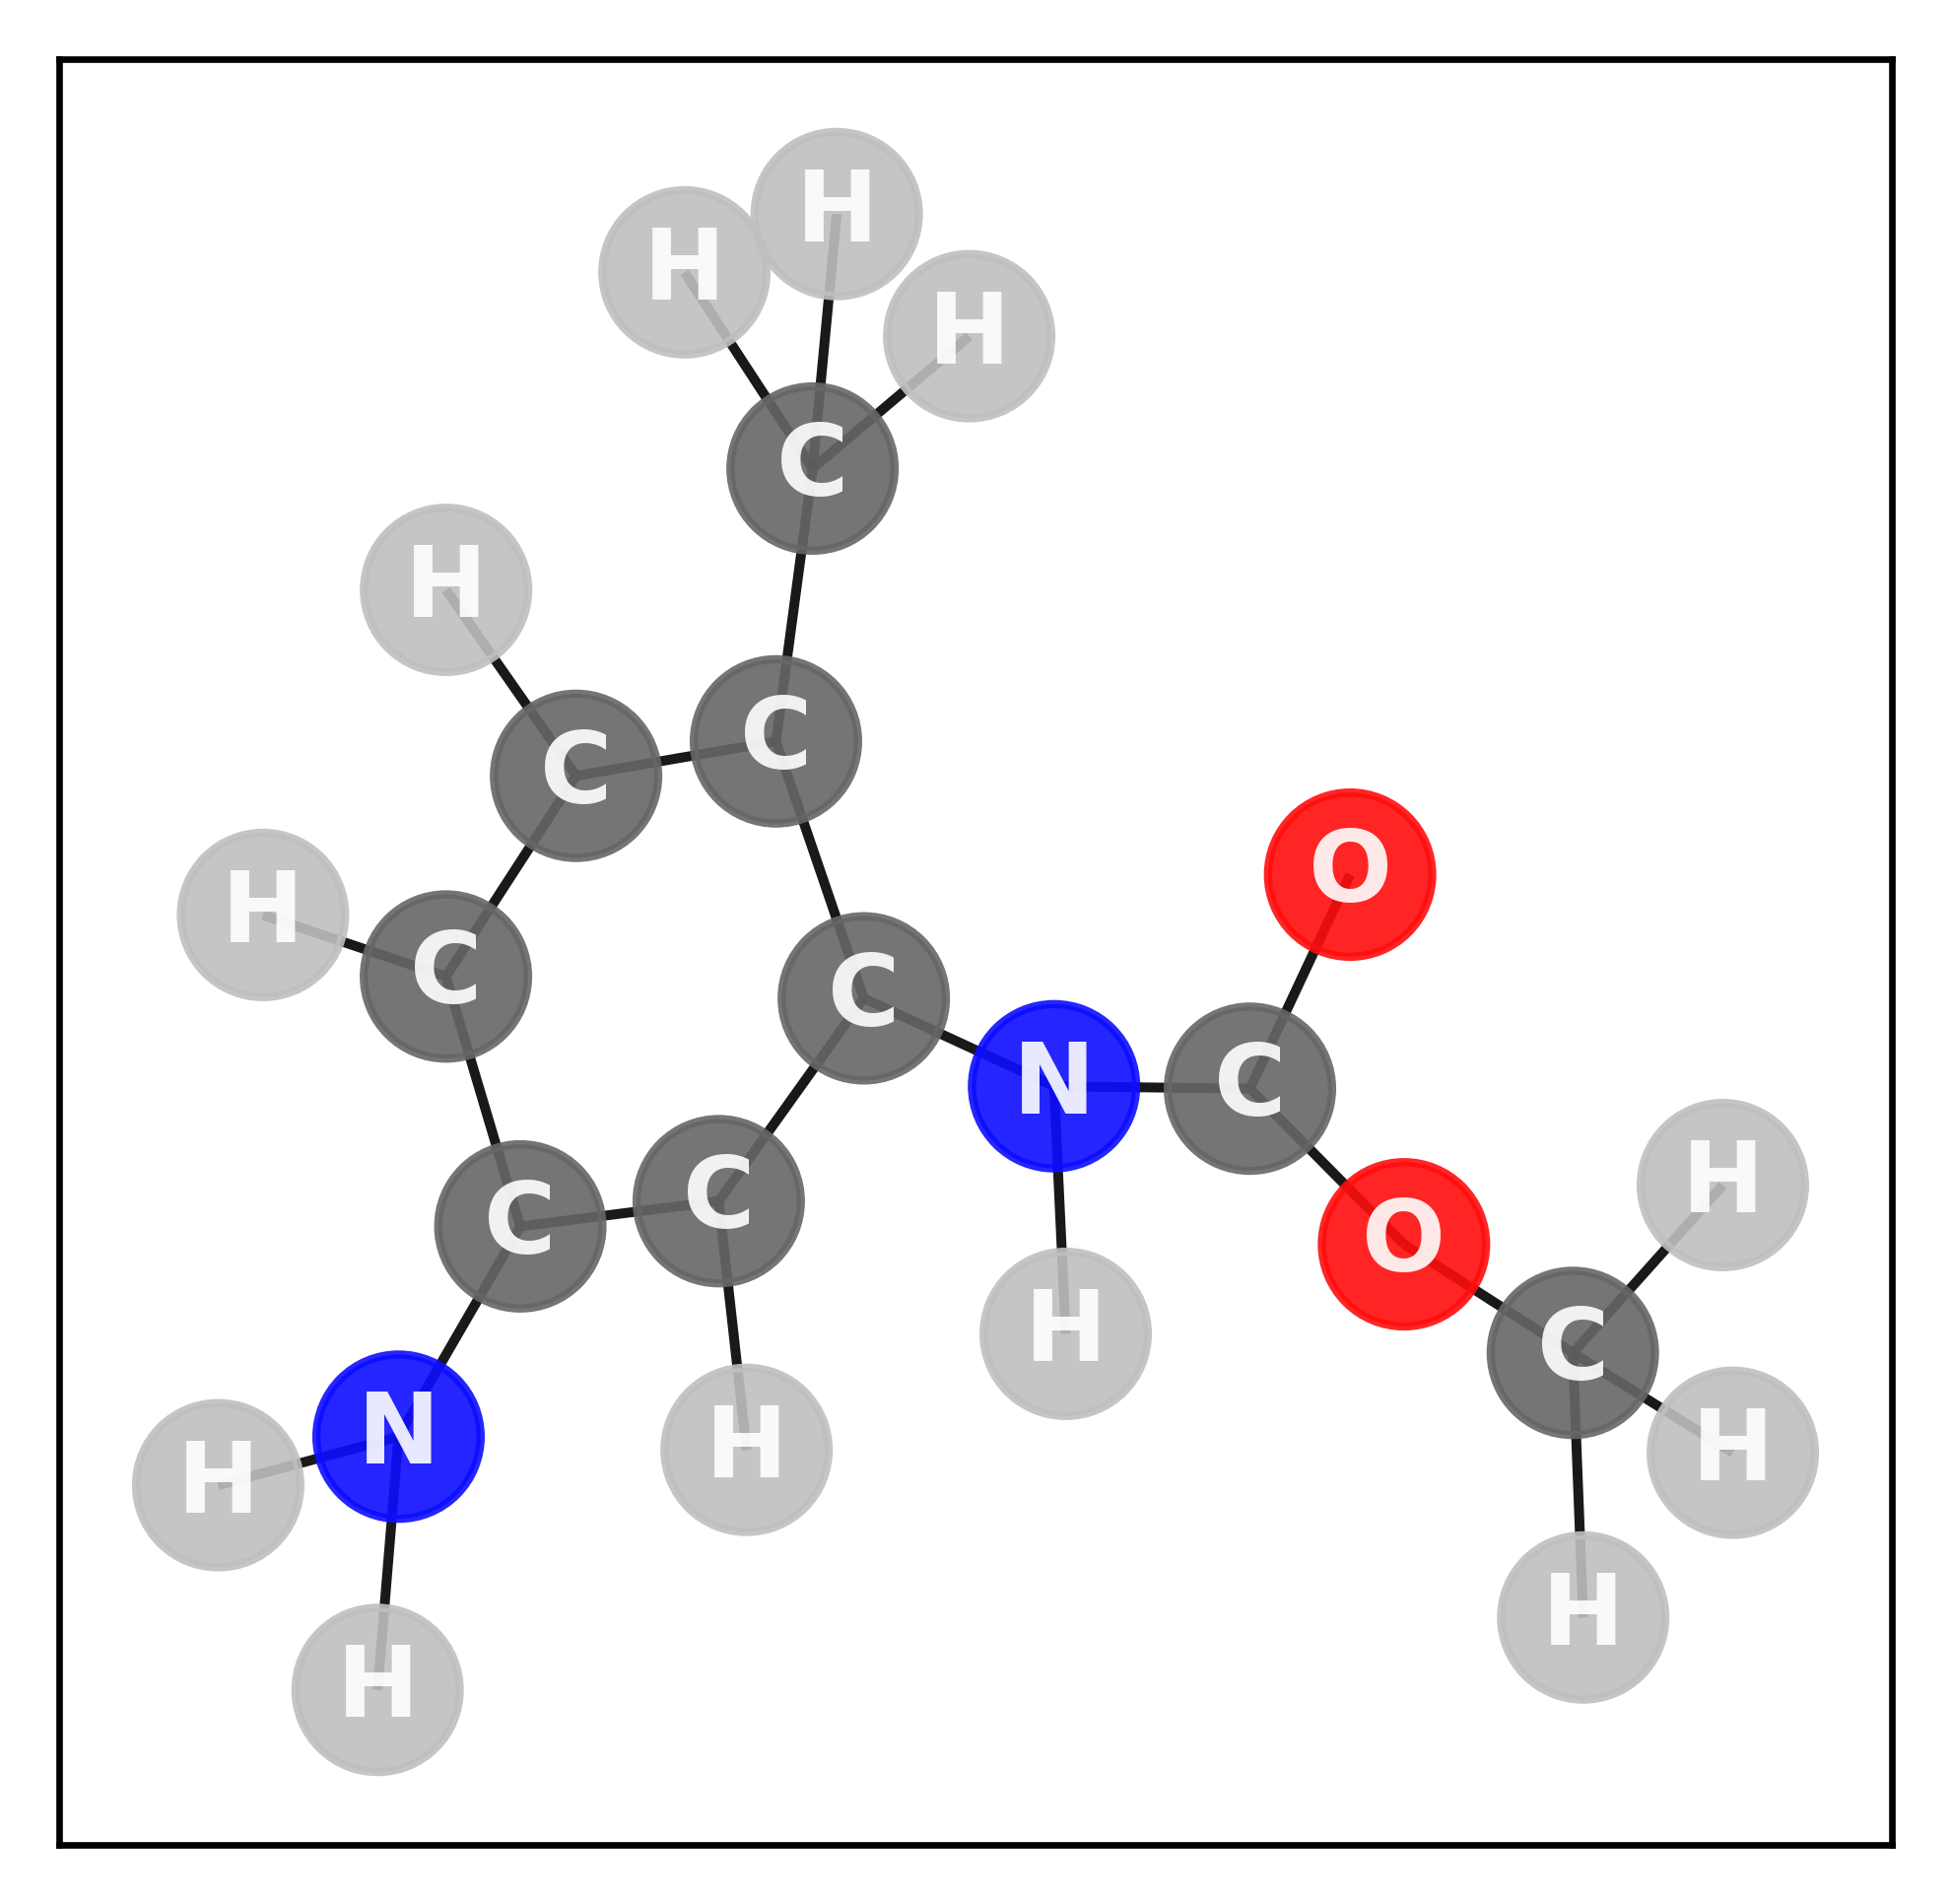

System: au-mol_18
GNN energy = -157.89 eV 
VASP energy = -156.93564073000005 eV
Prediction error = 0.96 eV
-----------------------------------


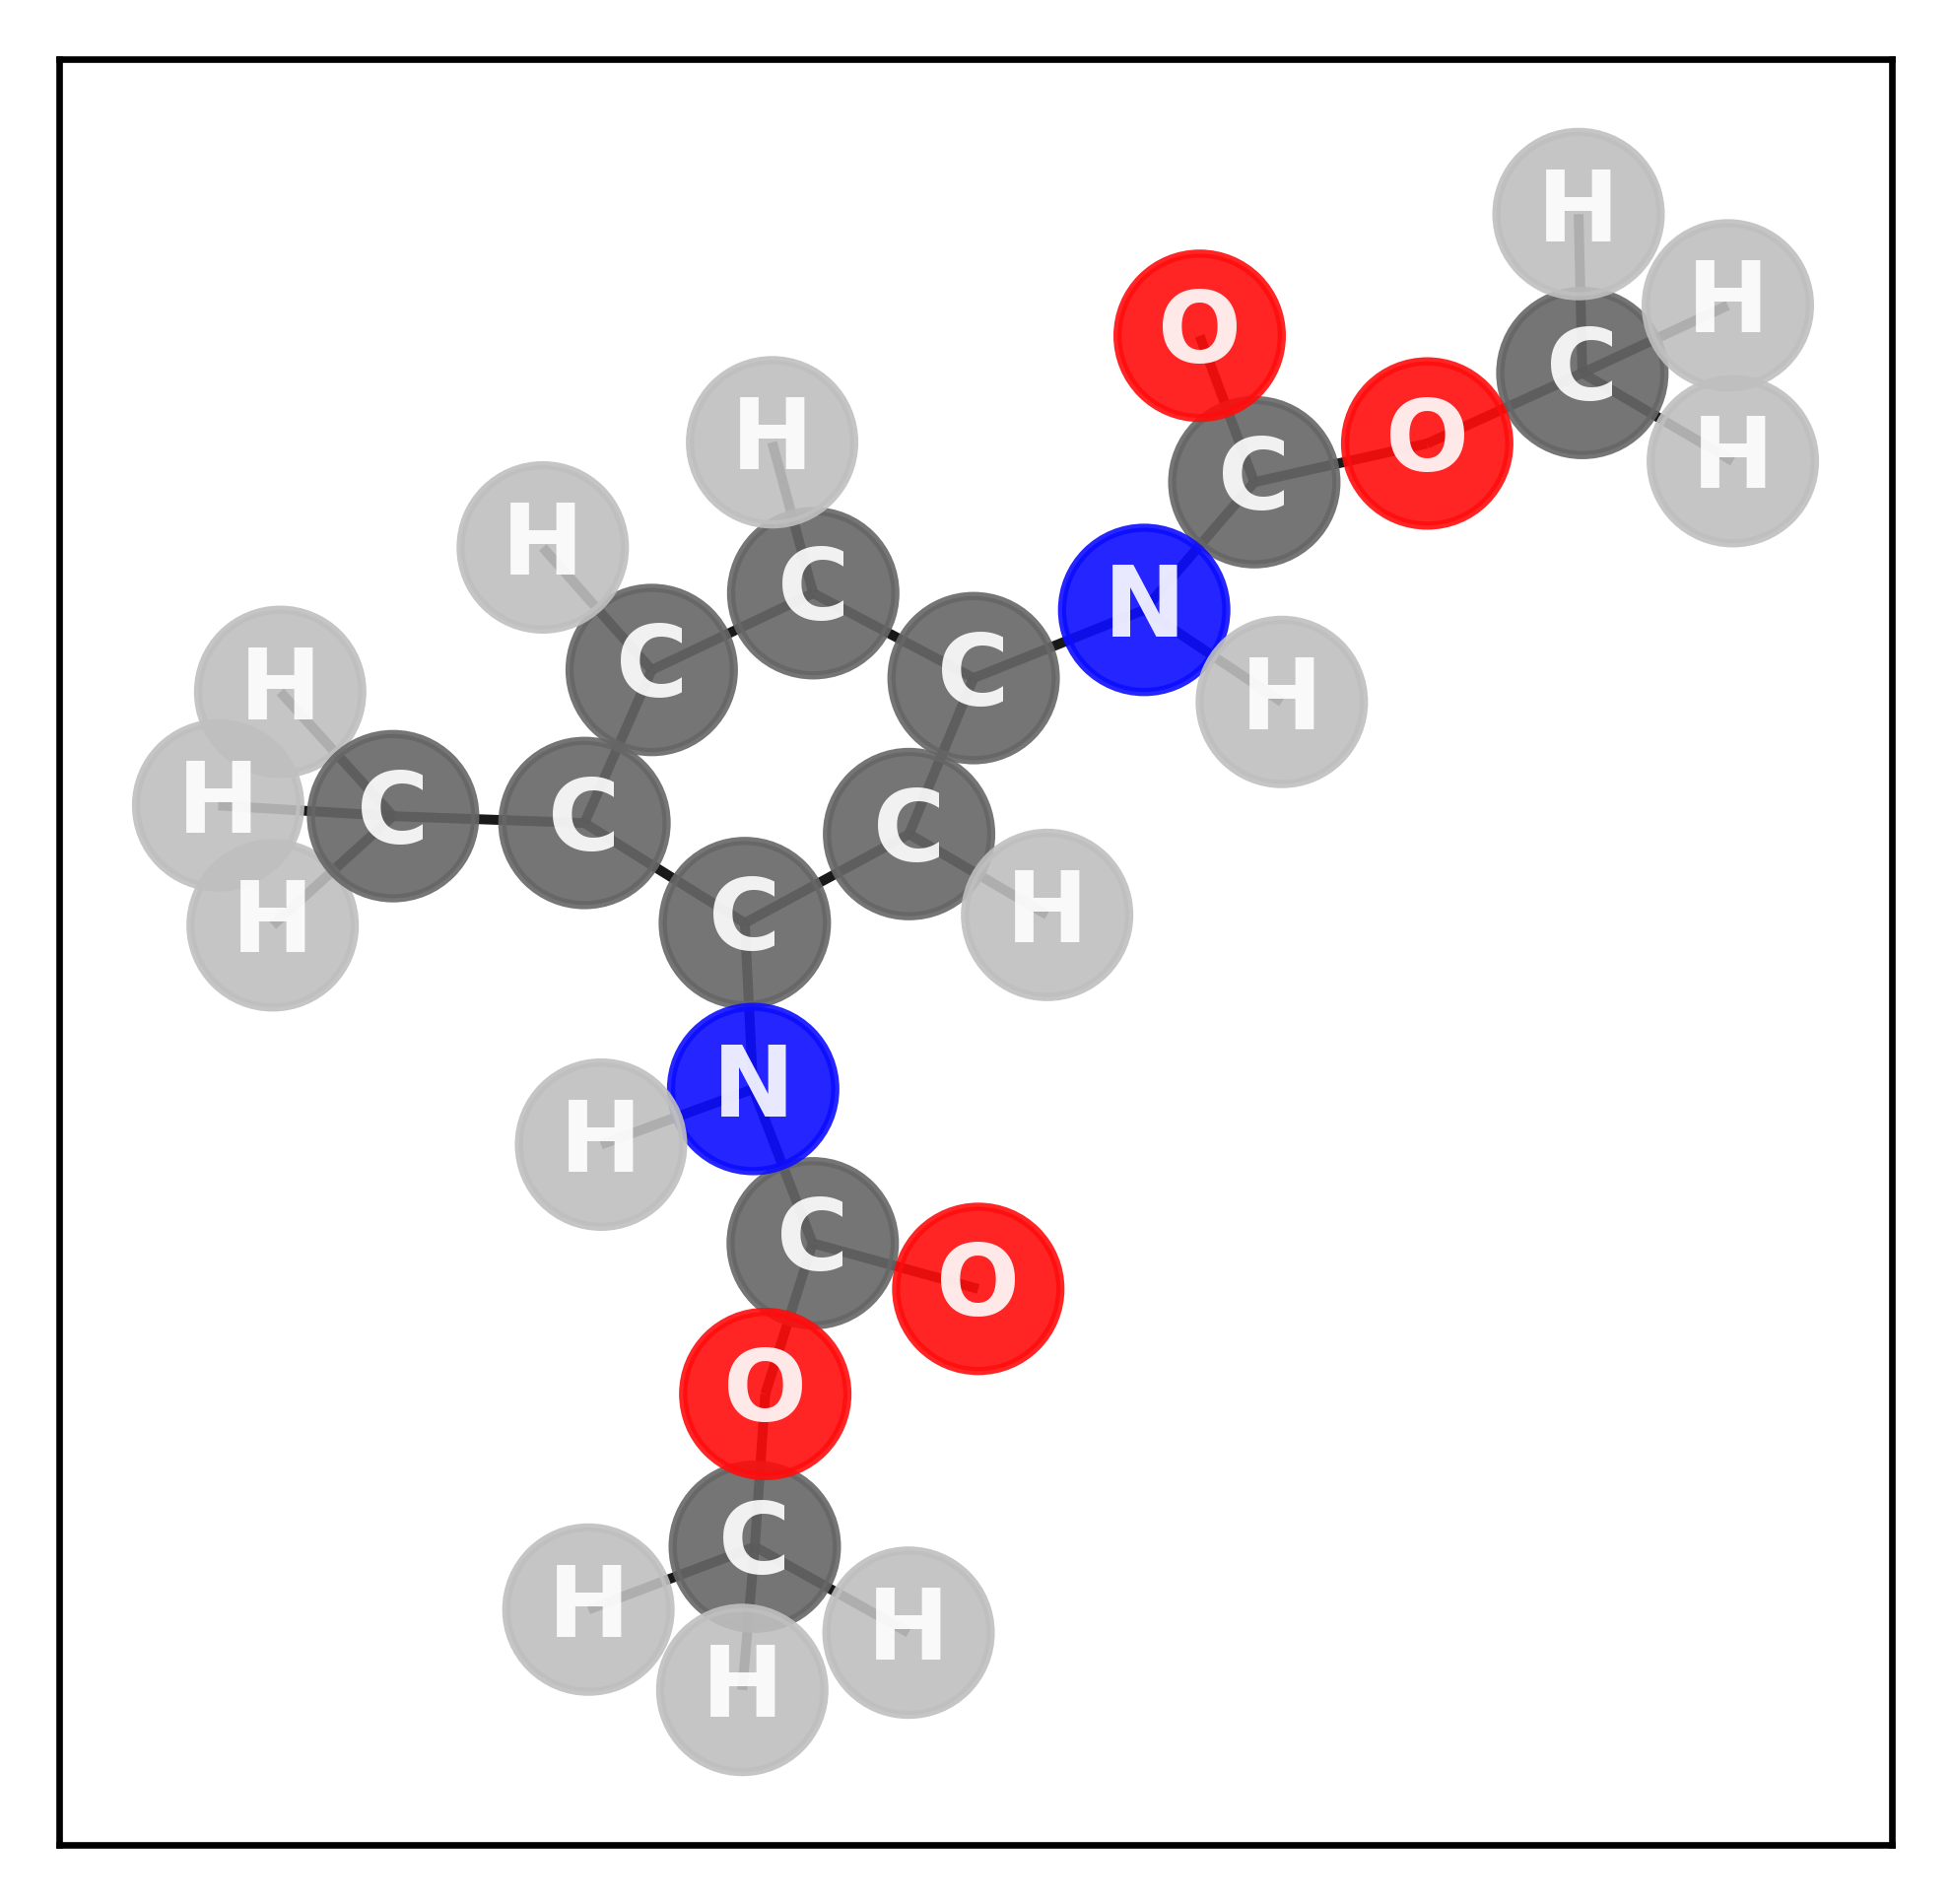

System: au-mol_19
GNN energy = -195.41 eV 
VASP energy = -196.24380310000004 eV
Prediction error = -0.83 eV
-----------------------------------


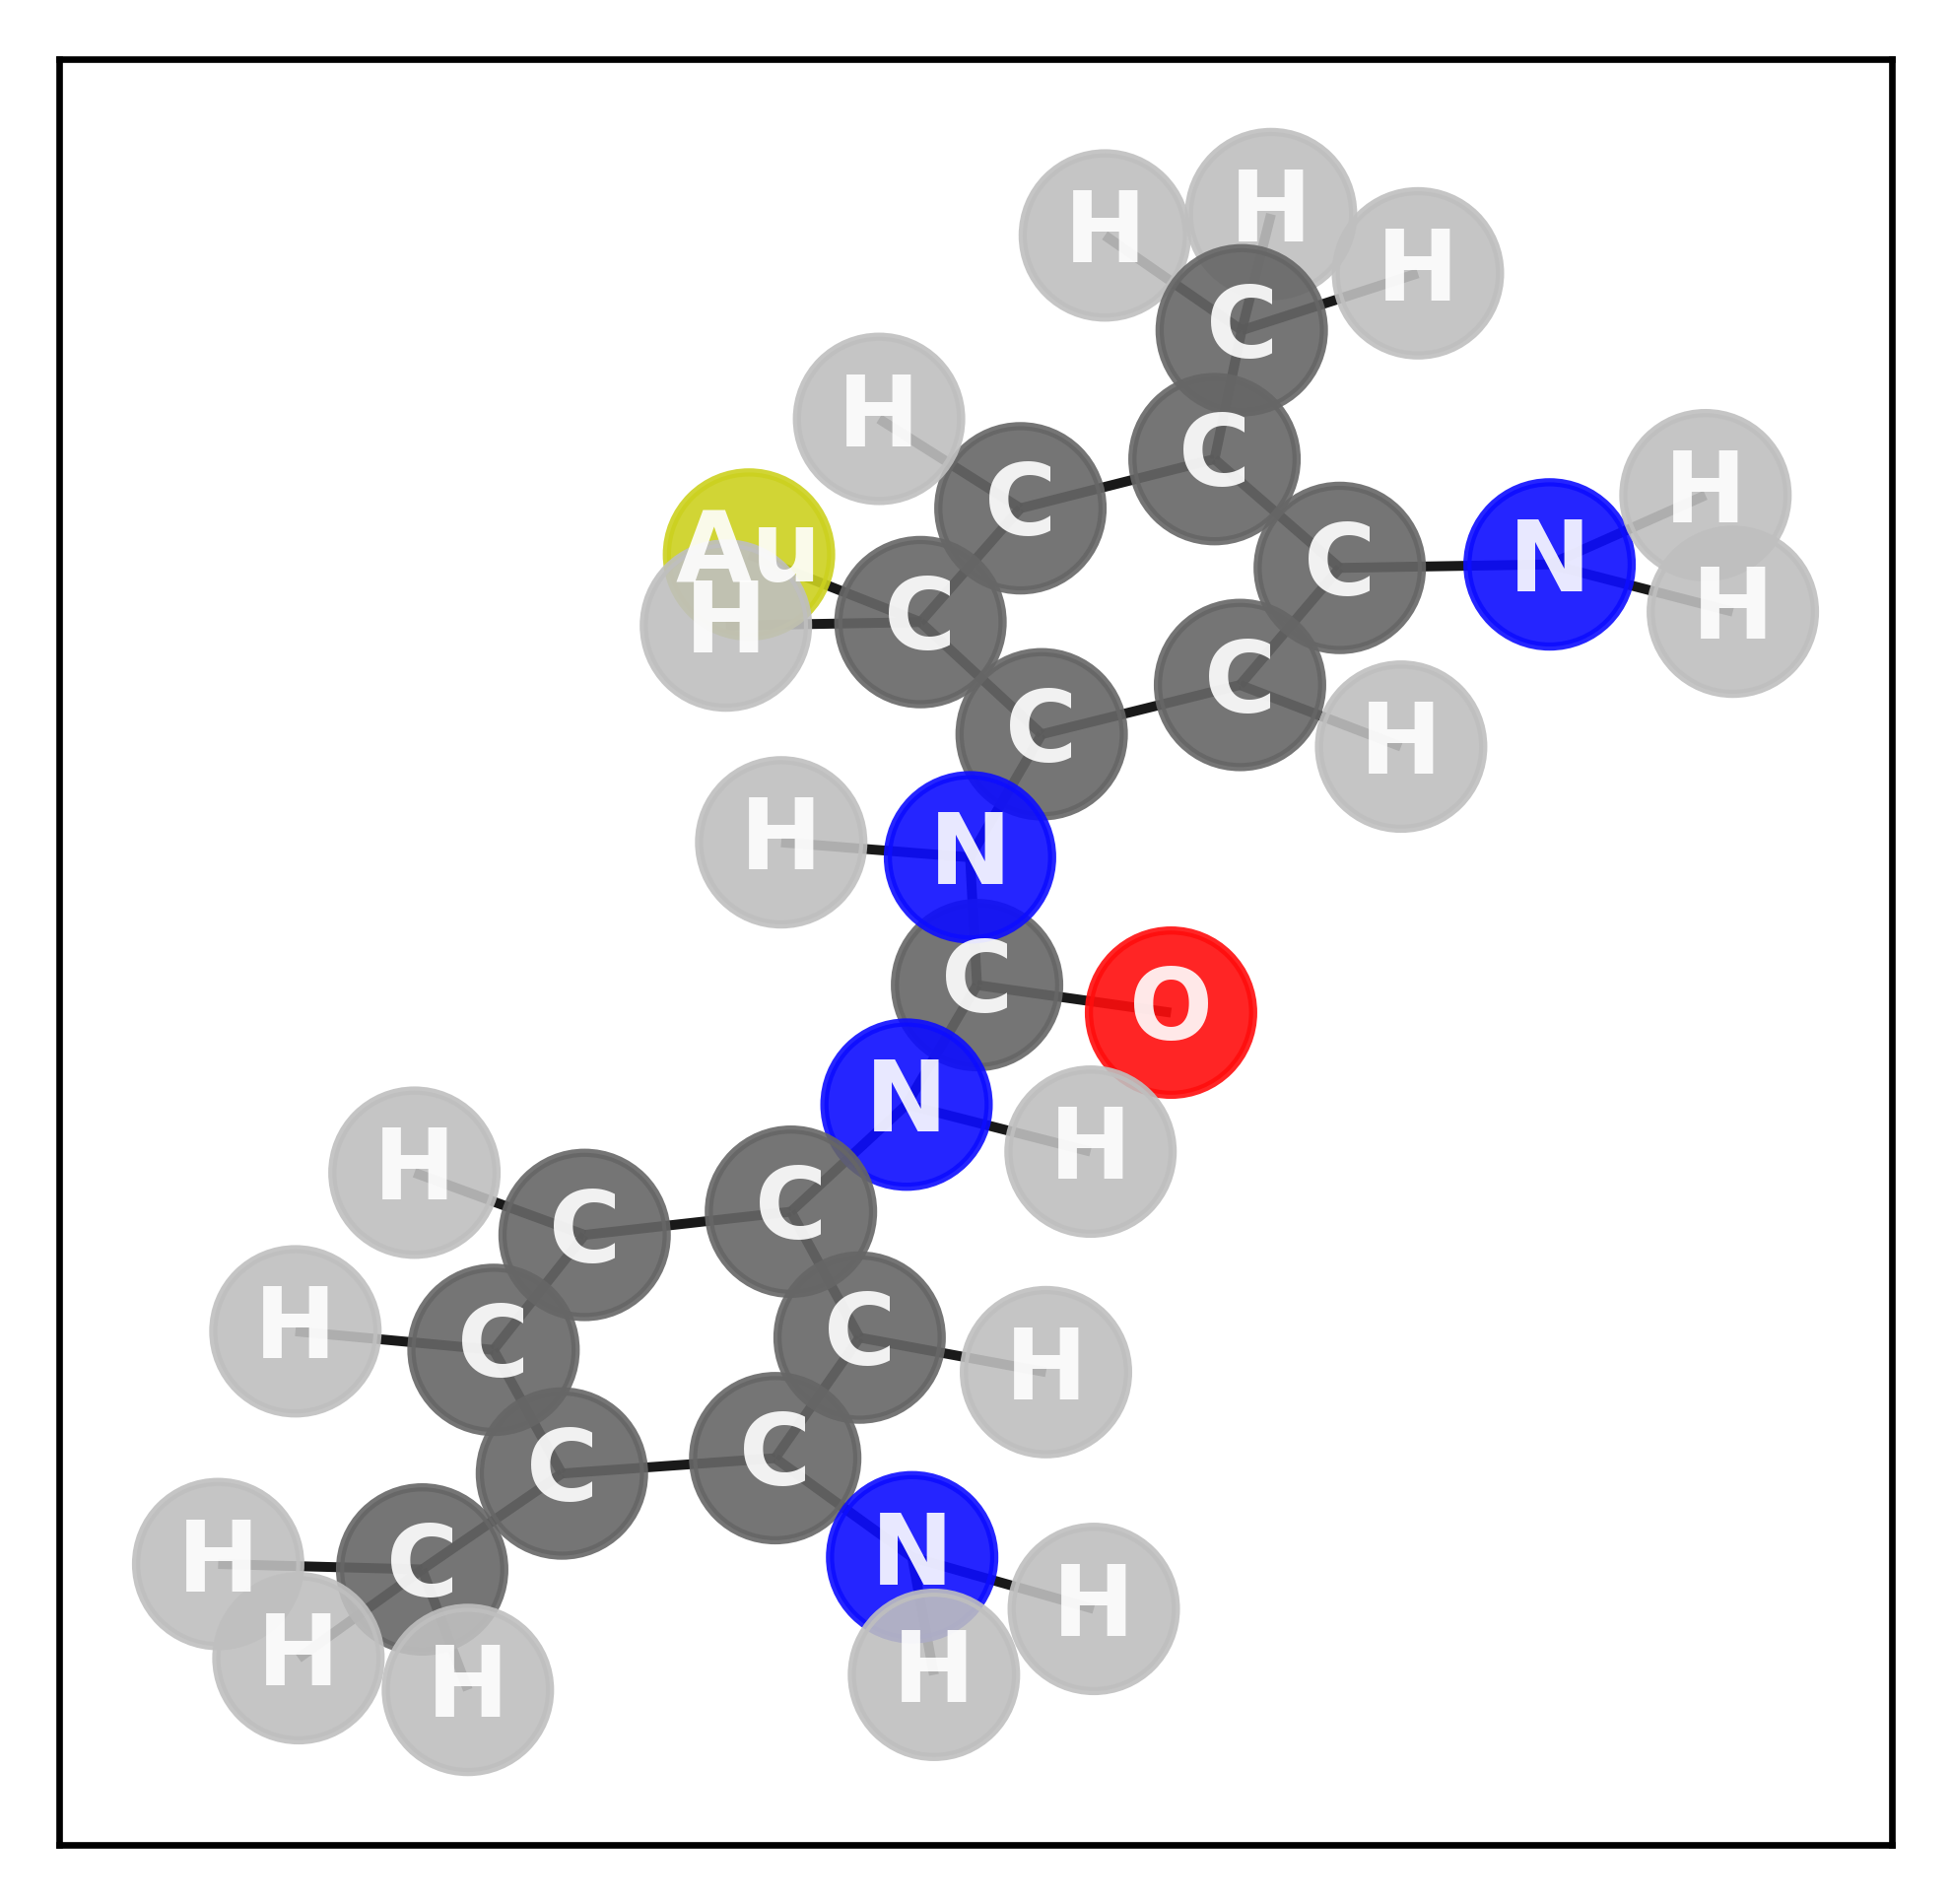

System: au-mol_41
GNN energy = -239.51 eV 
VASP energy = -244.31561998000006 eV
Prediction error = -4.80 eV
-----------------------------------


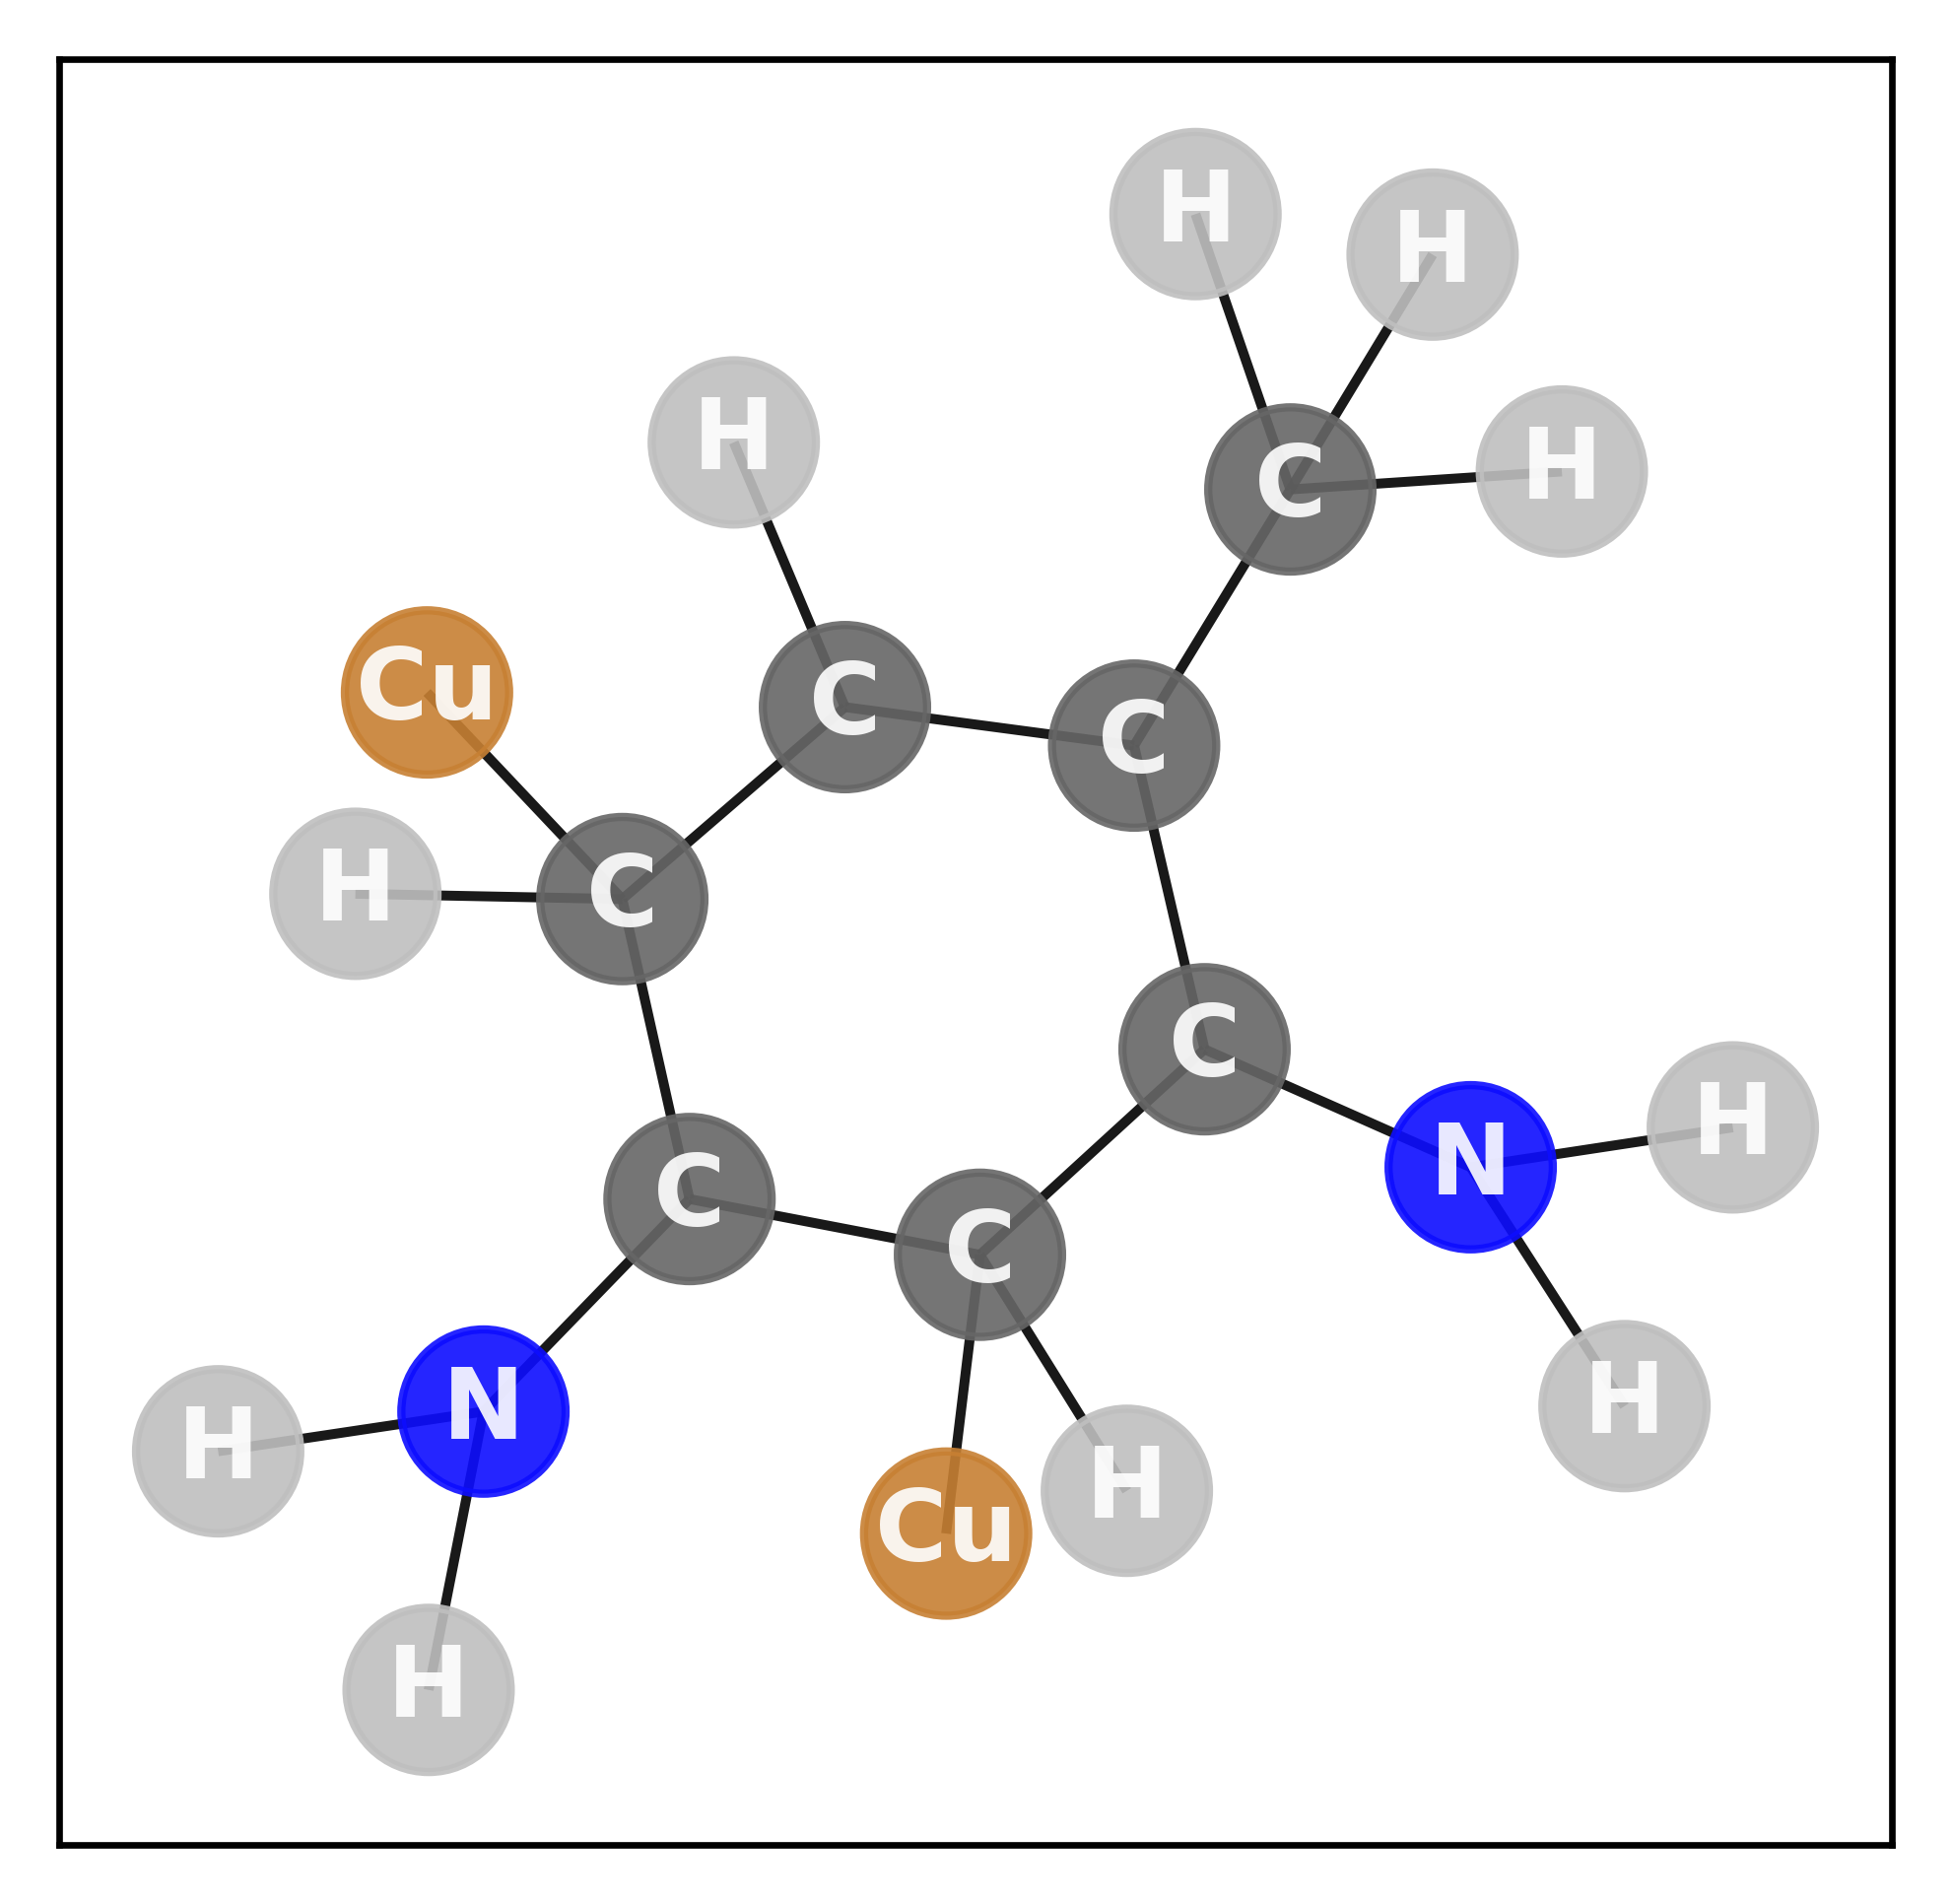

System: cu-mol_16
GNN energy = -118.33 eV 
VASP energy = -118.46814558999995 eV
Prediction error = -0.13 eV
-----------------------------------


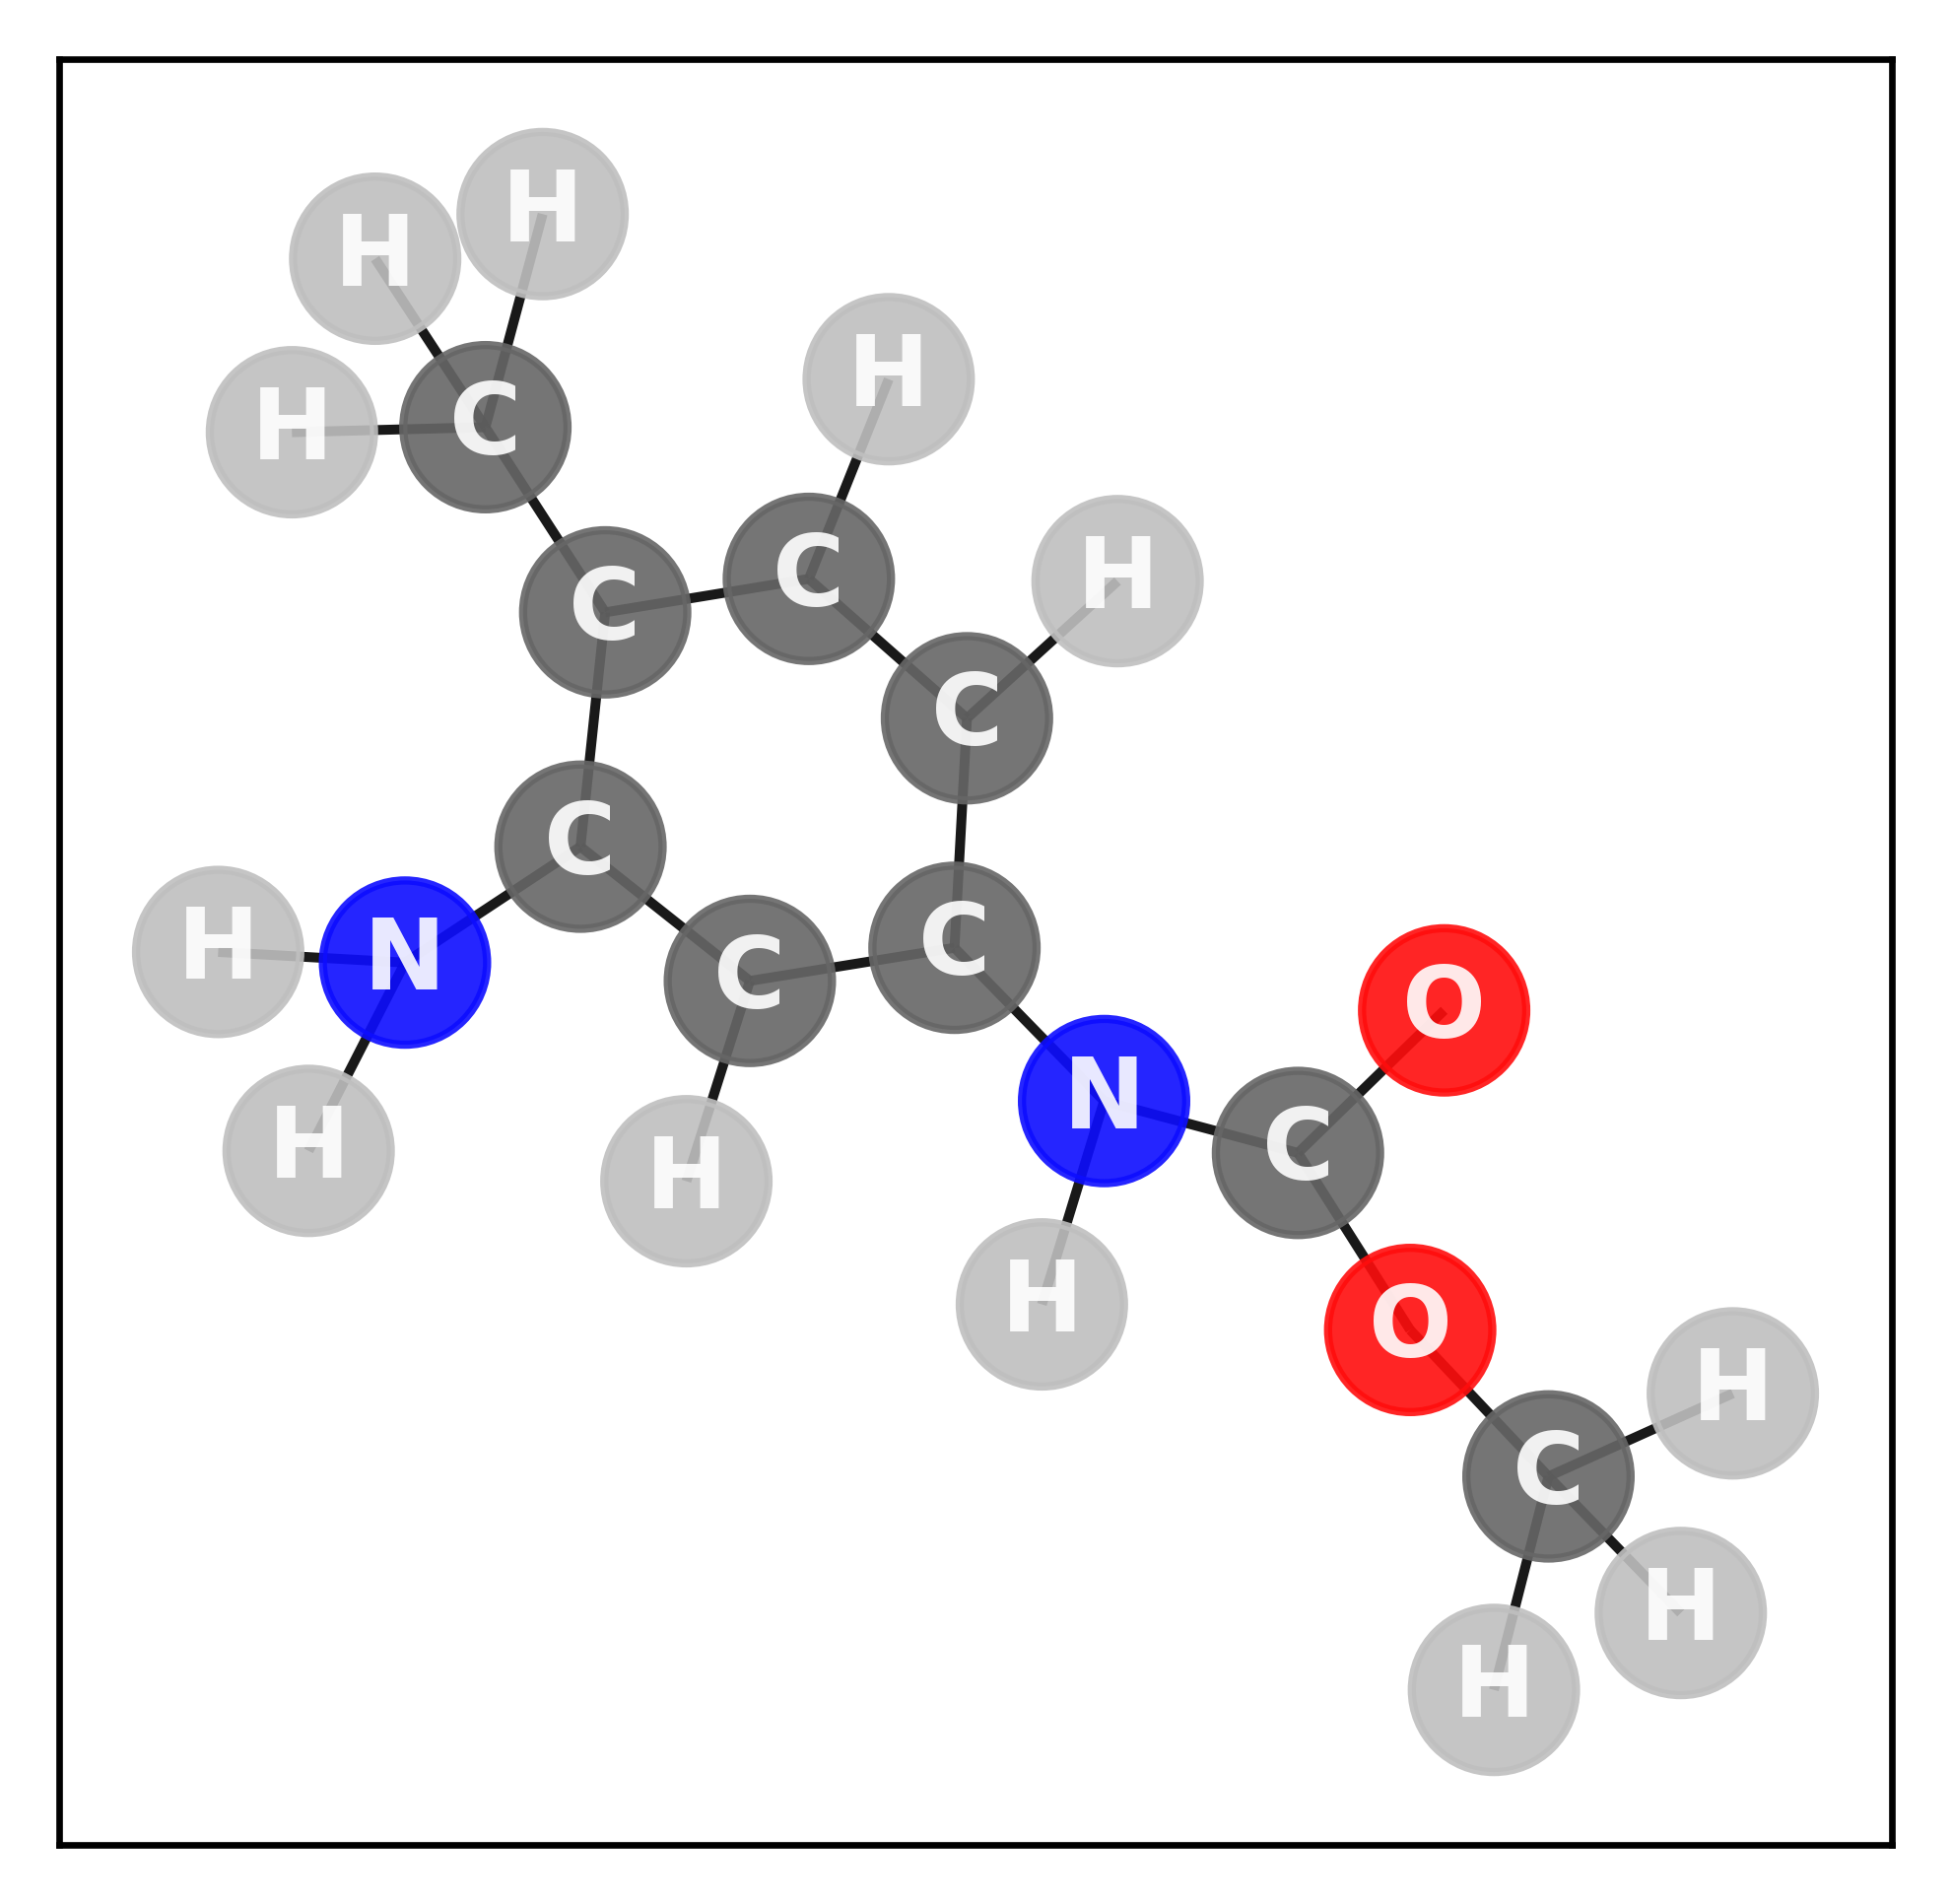

System: cu-mol_17
GNN energy = -157.89 eV 
VASP energy = -157.59770521999997 eV
Prediction error = 0.29 eV
-----------------------------------


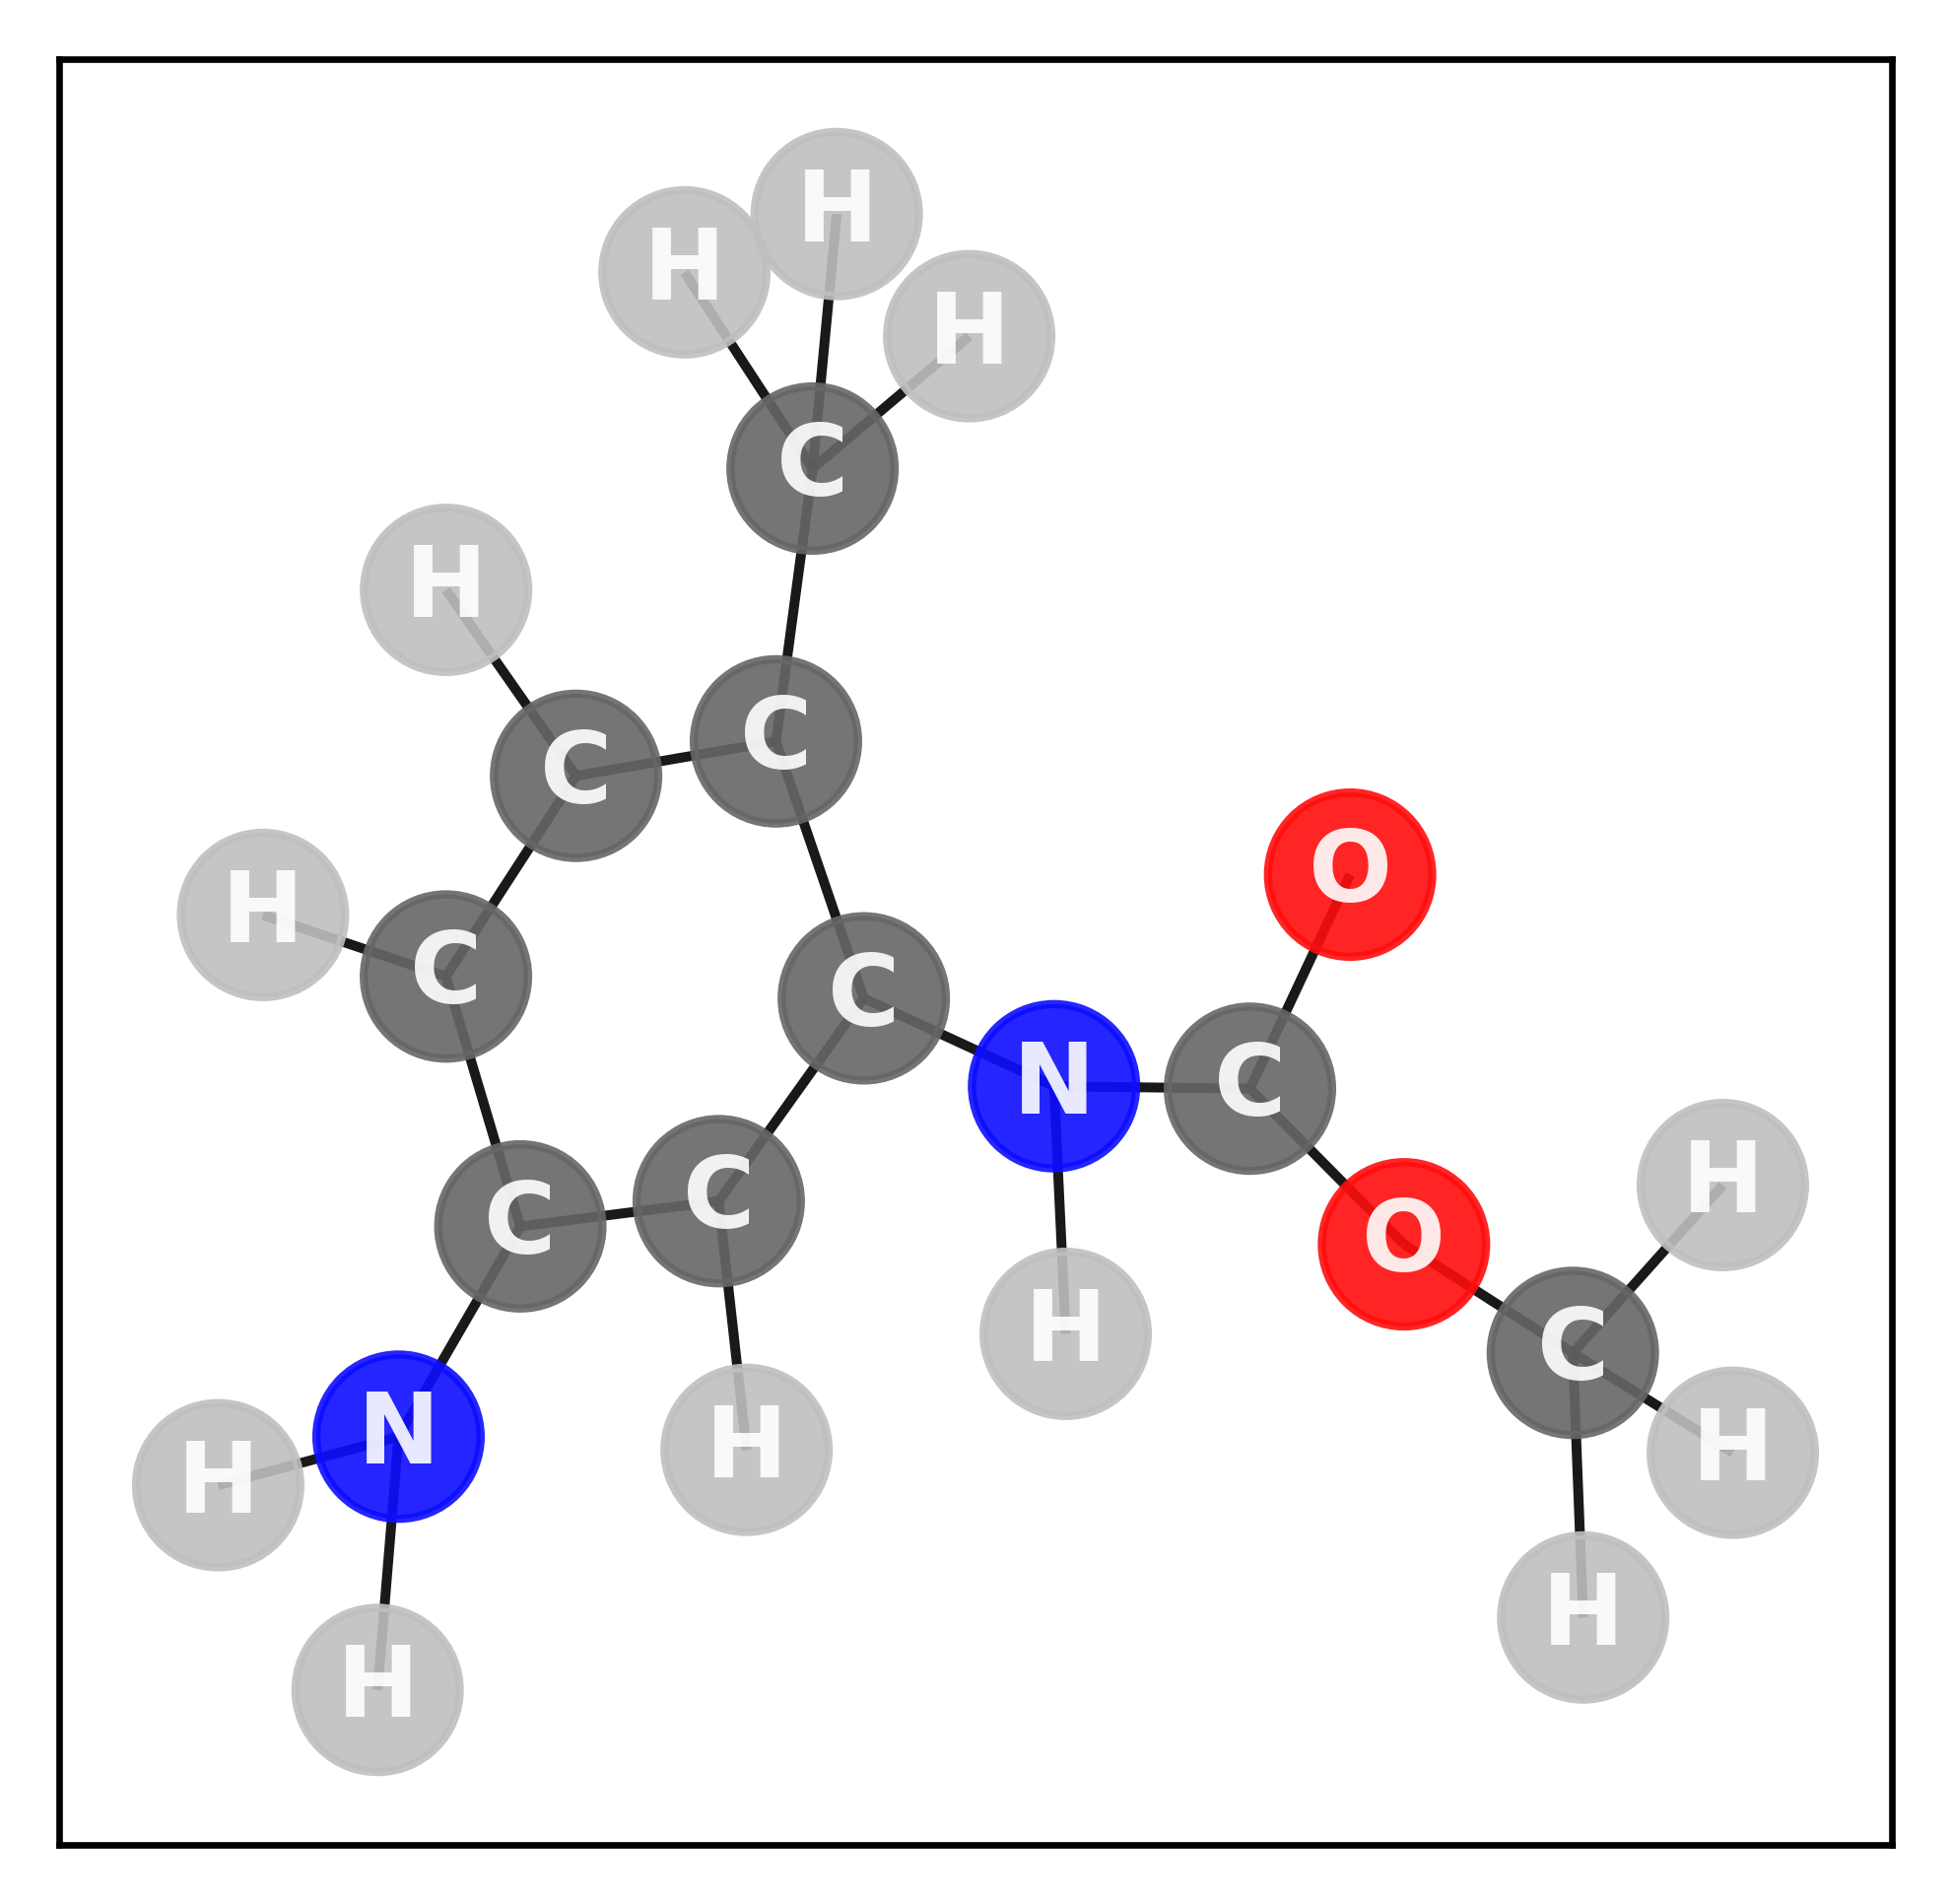

System: cu-mol_18
GNN energy = -157.89 eV 
VASP energy = -157.54930794999996 eV
Prediction error = 0.35 eV
-----------------------------------


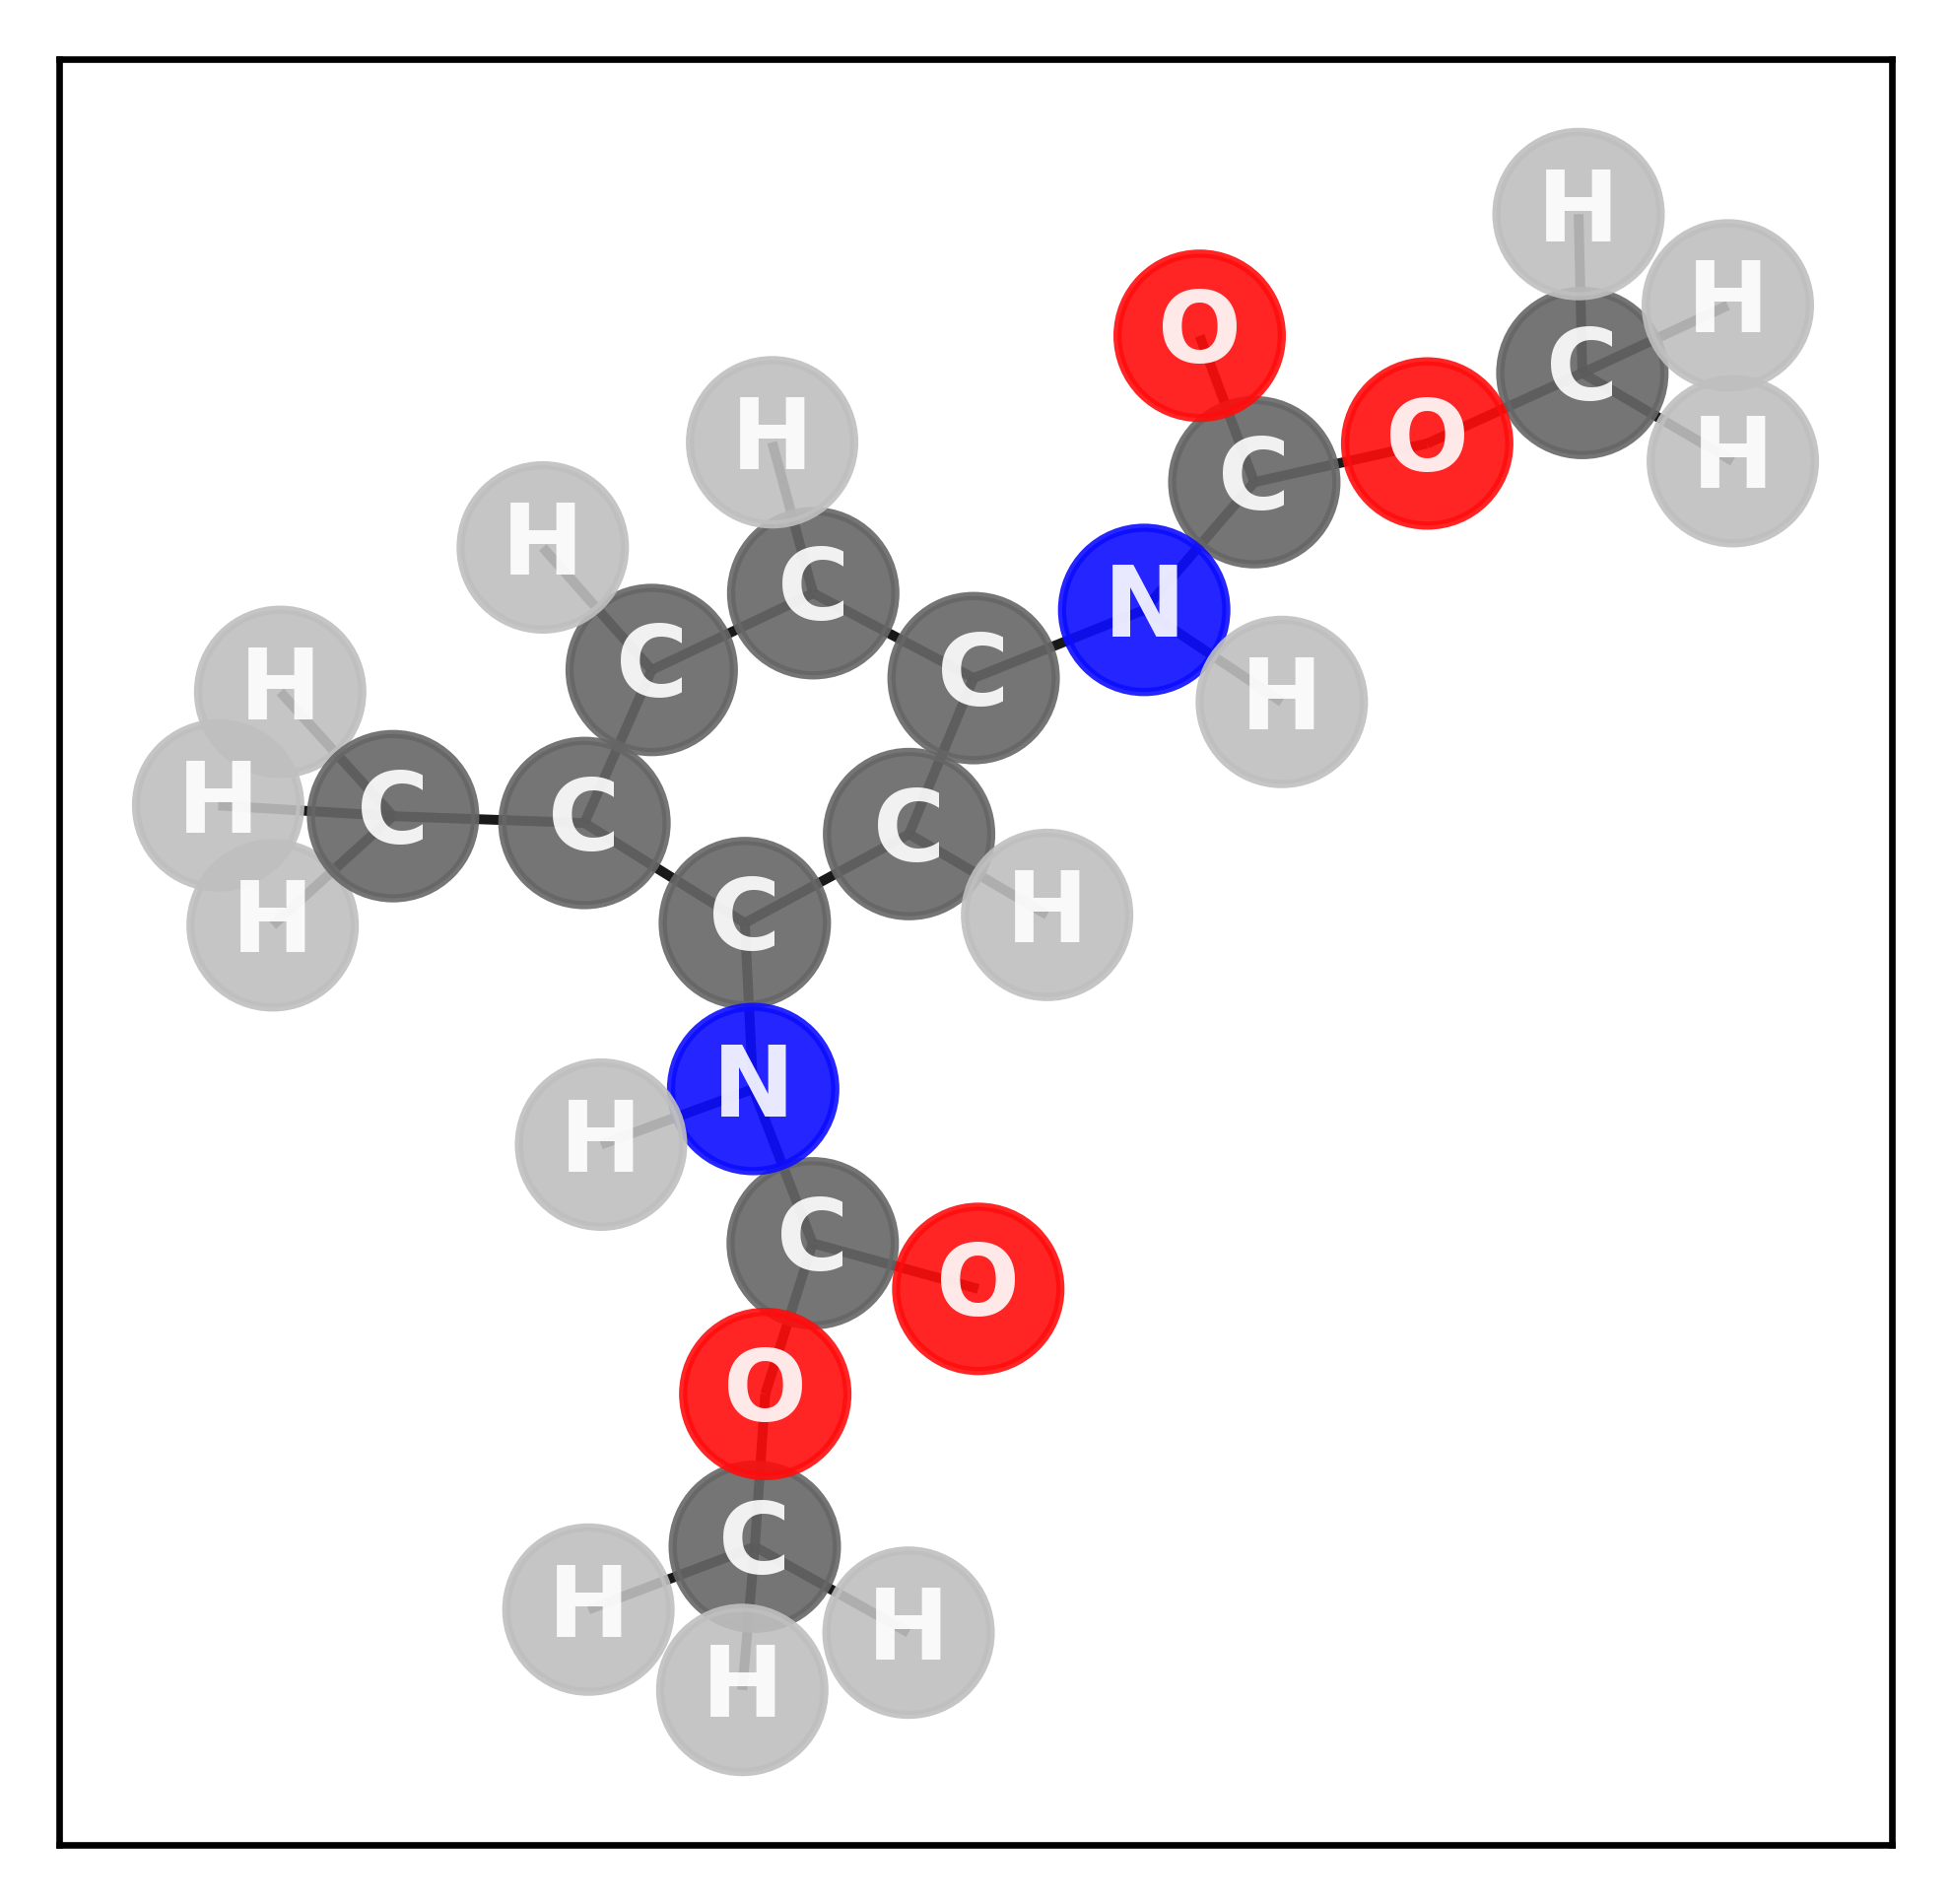

System: cu-mol_19
GNN energy = -195.41 eV 
VASP energy = -196.82126069999993 eV
Prediction error = -1.41 eV
-----------------------------------


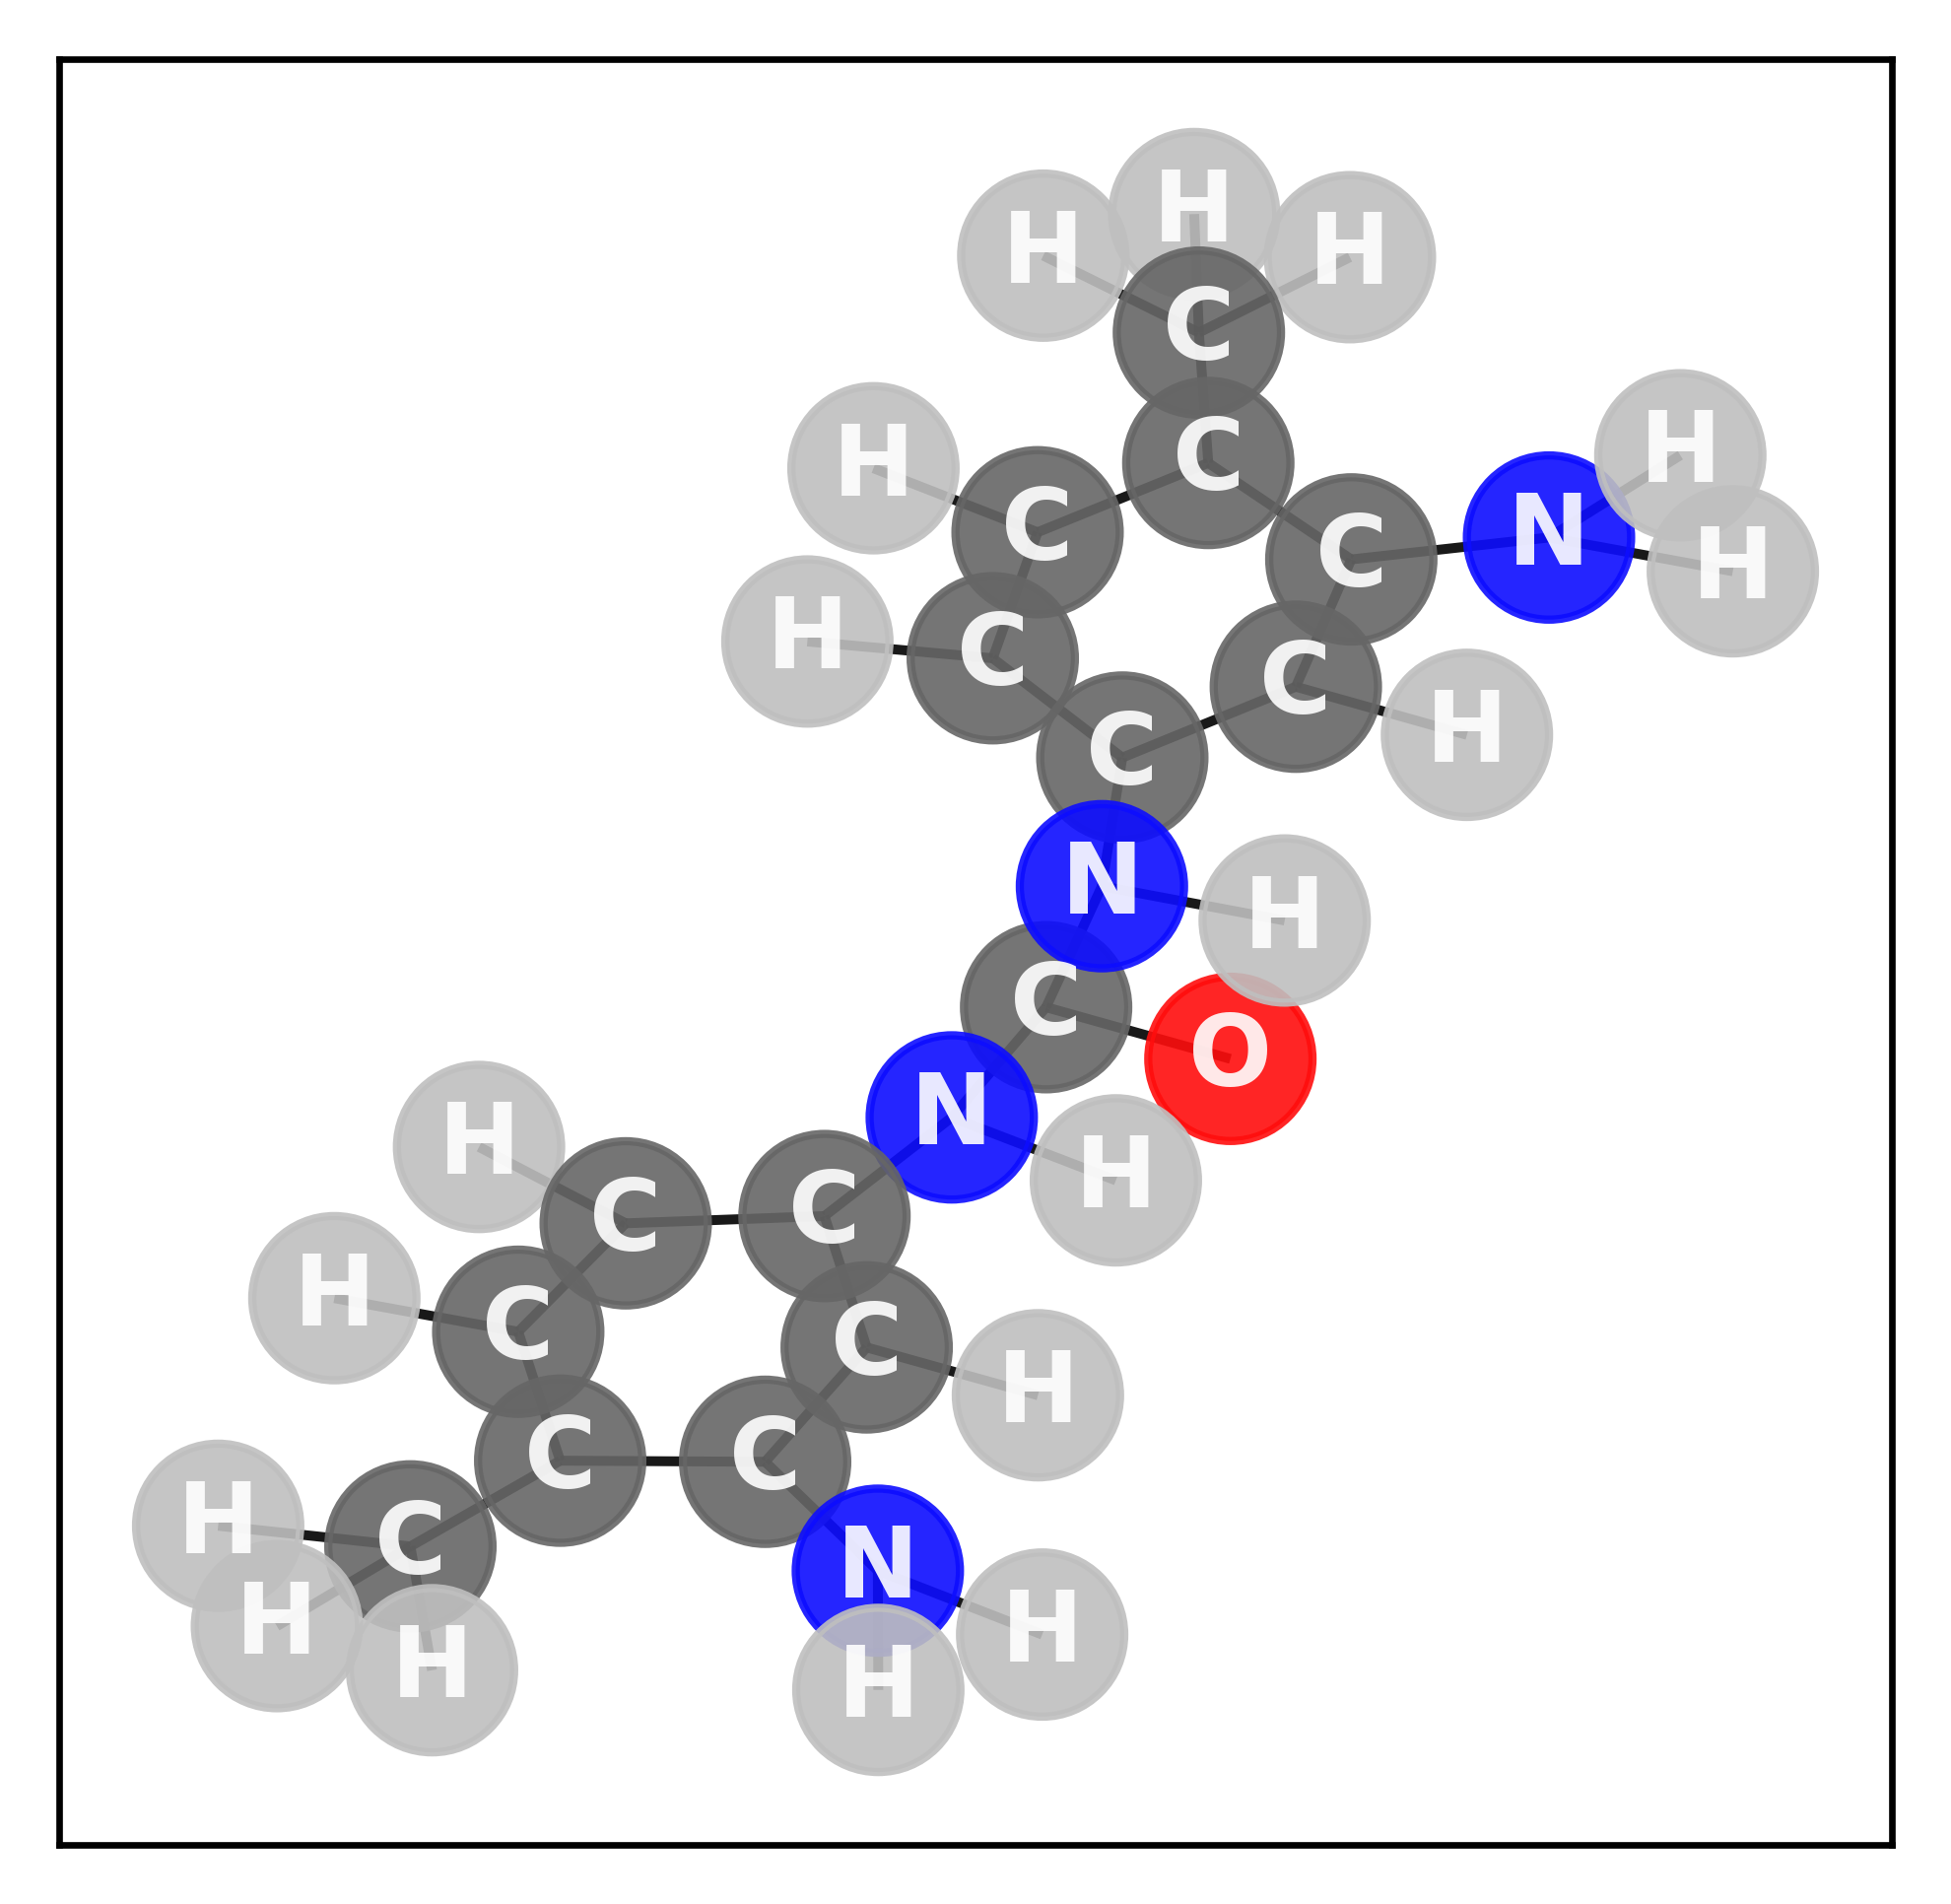

System: cu-mol_41
GNN energy = -239.22 eV 
VASP energy = -244.91745026 eV
Prediction error = -5.70 eV
-----------------------------------


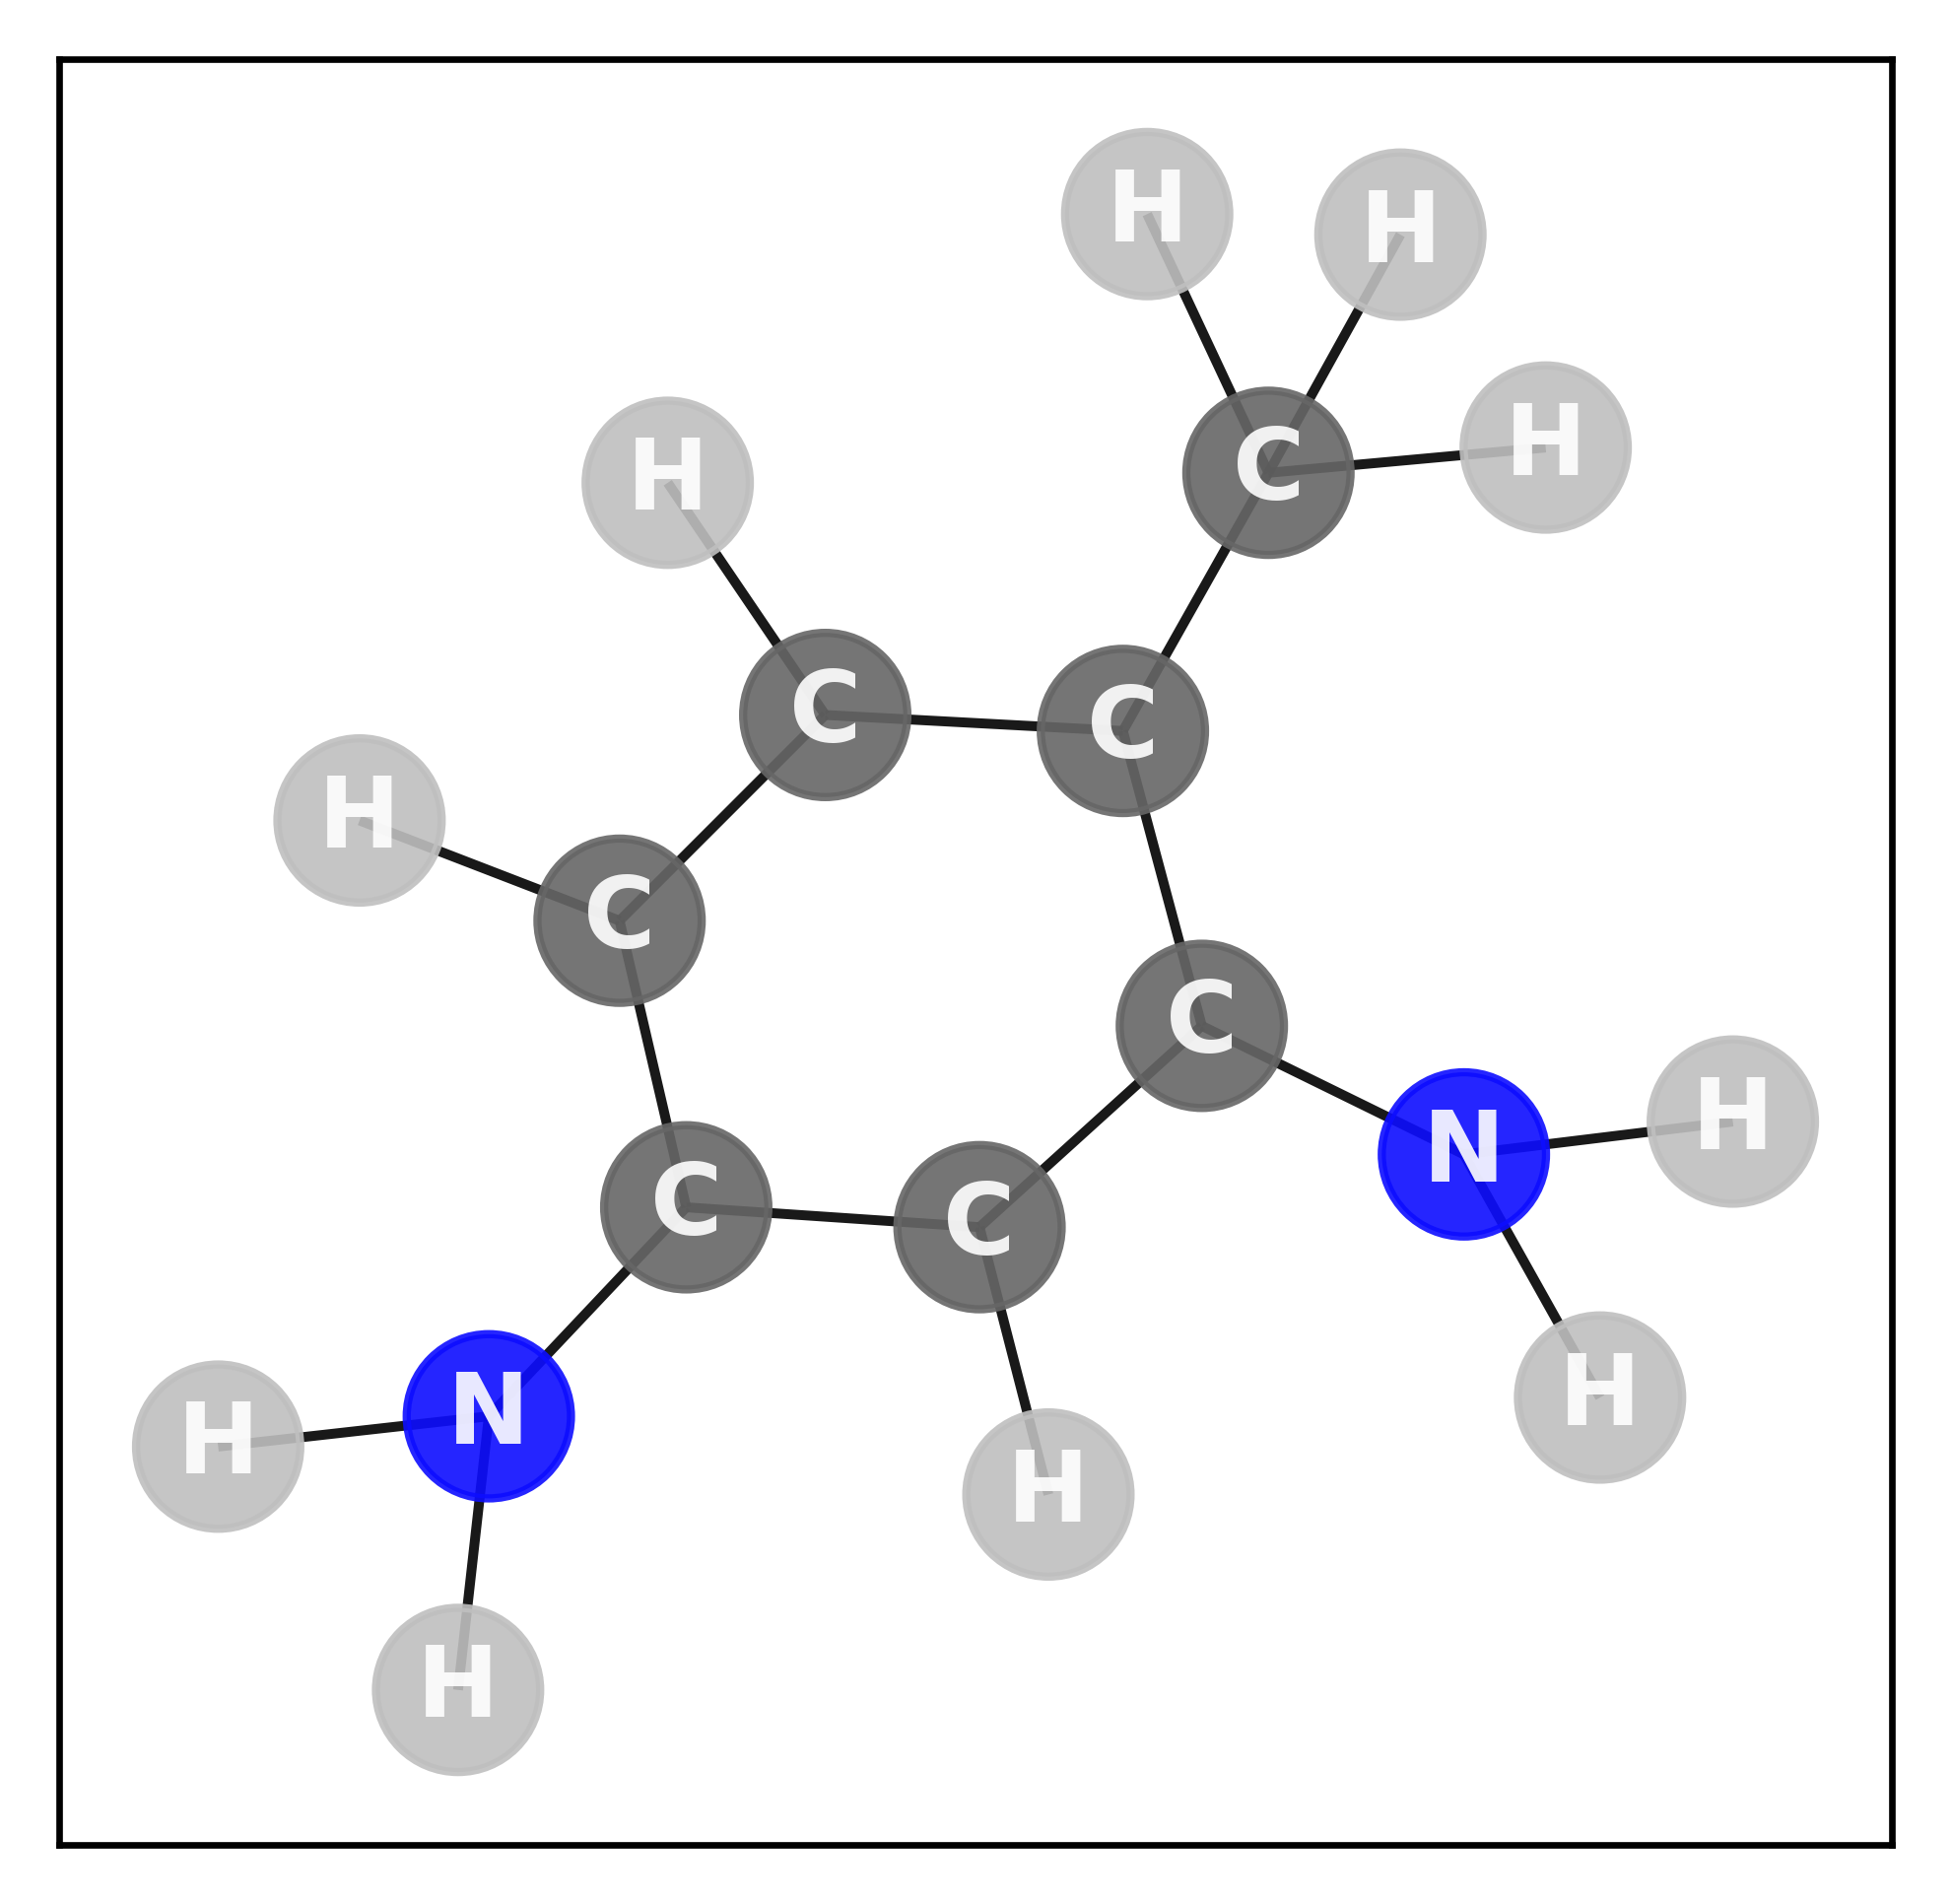

System: mol_16
GNN energy = -118.09 eV 
VASP energy = -117.29813031 eV
Prediction error = 0.79 eV
-----------------------------------


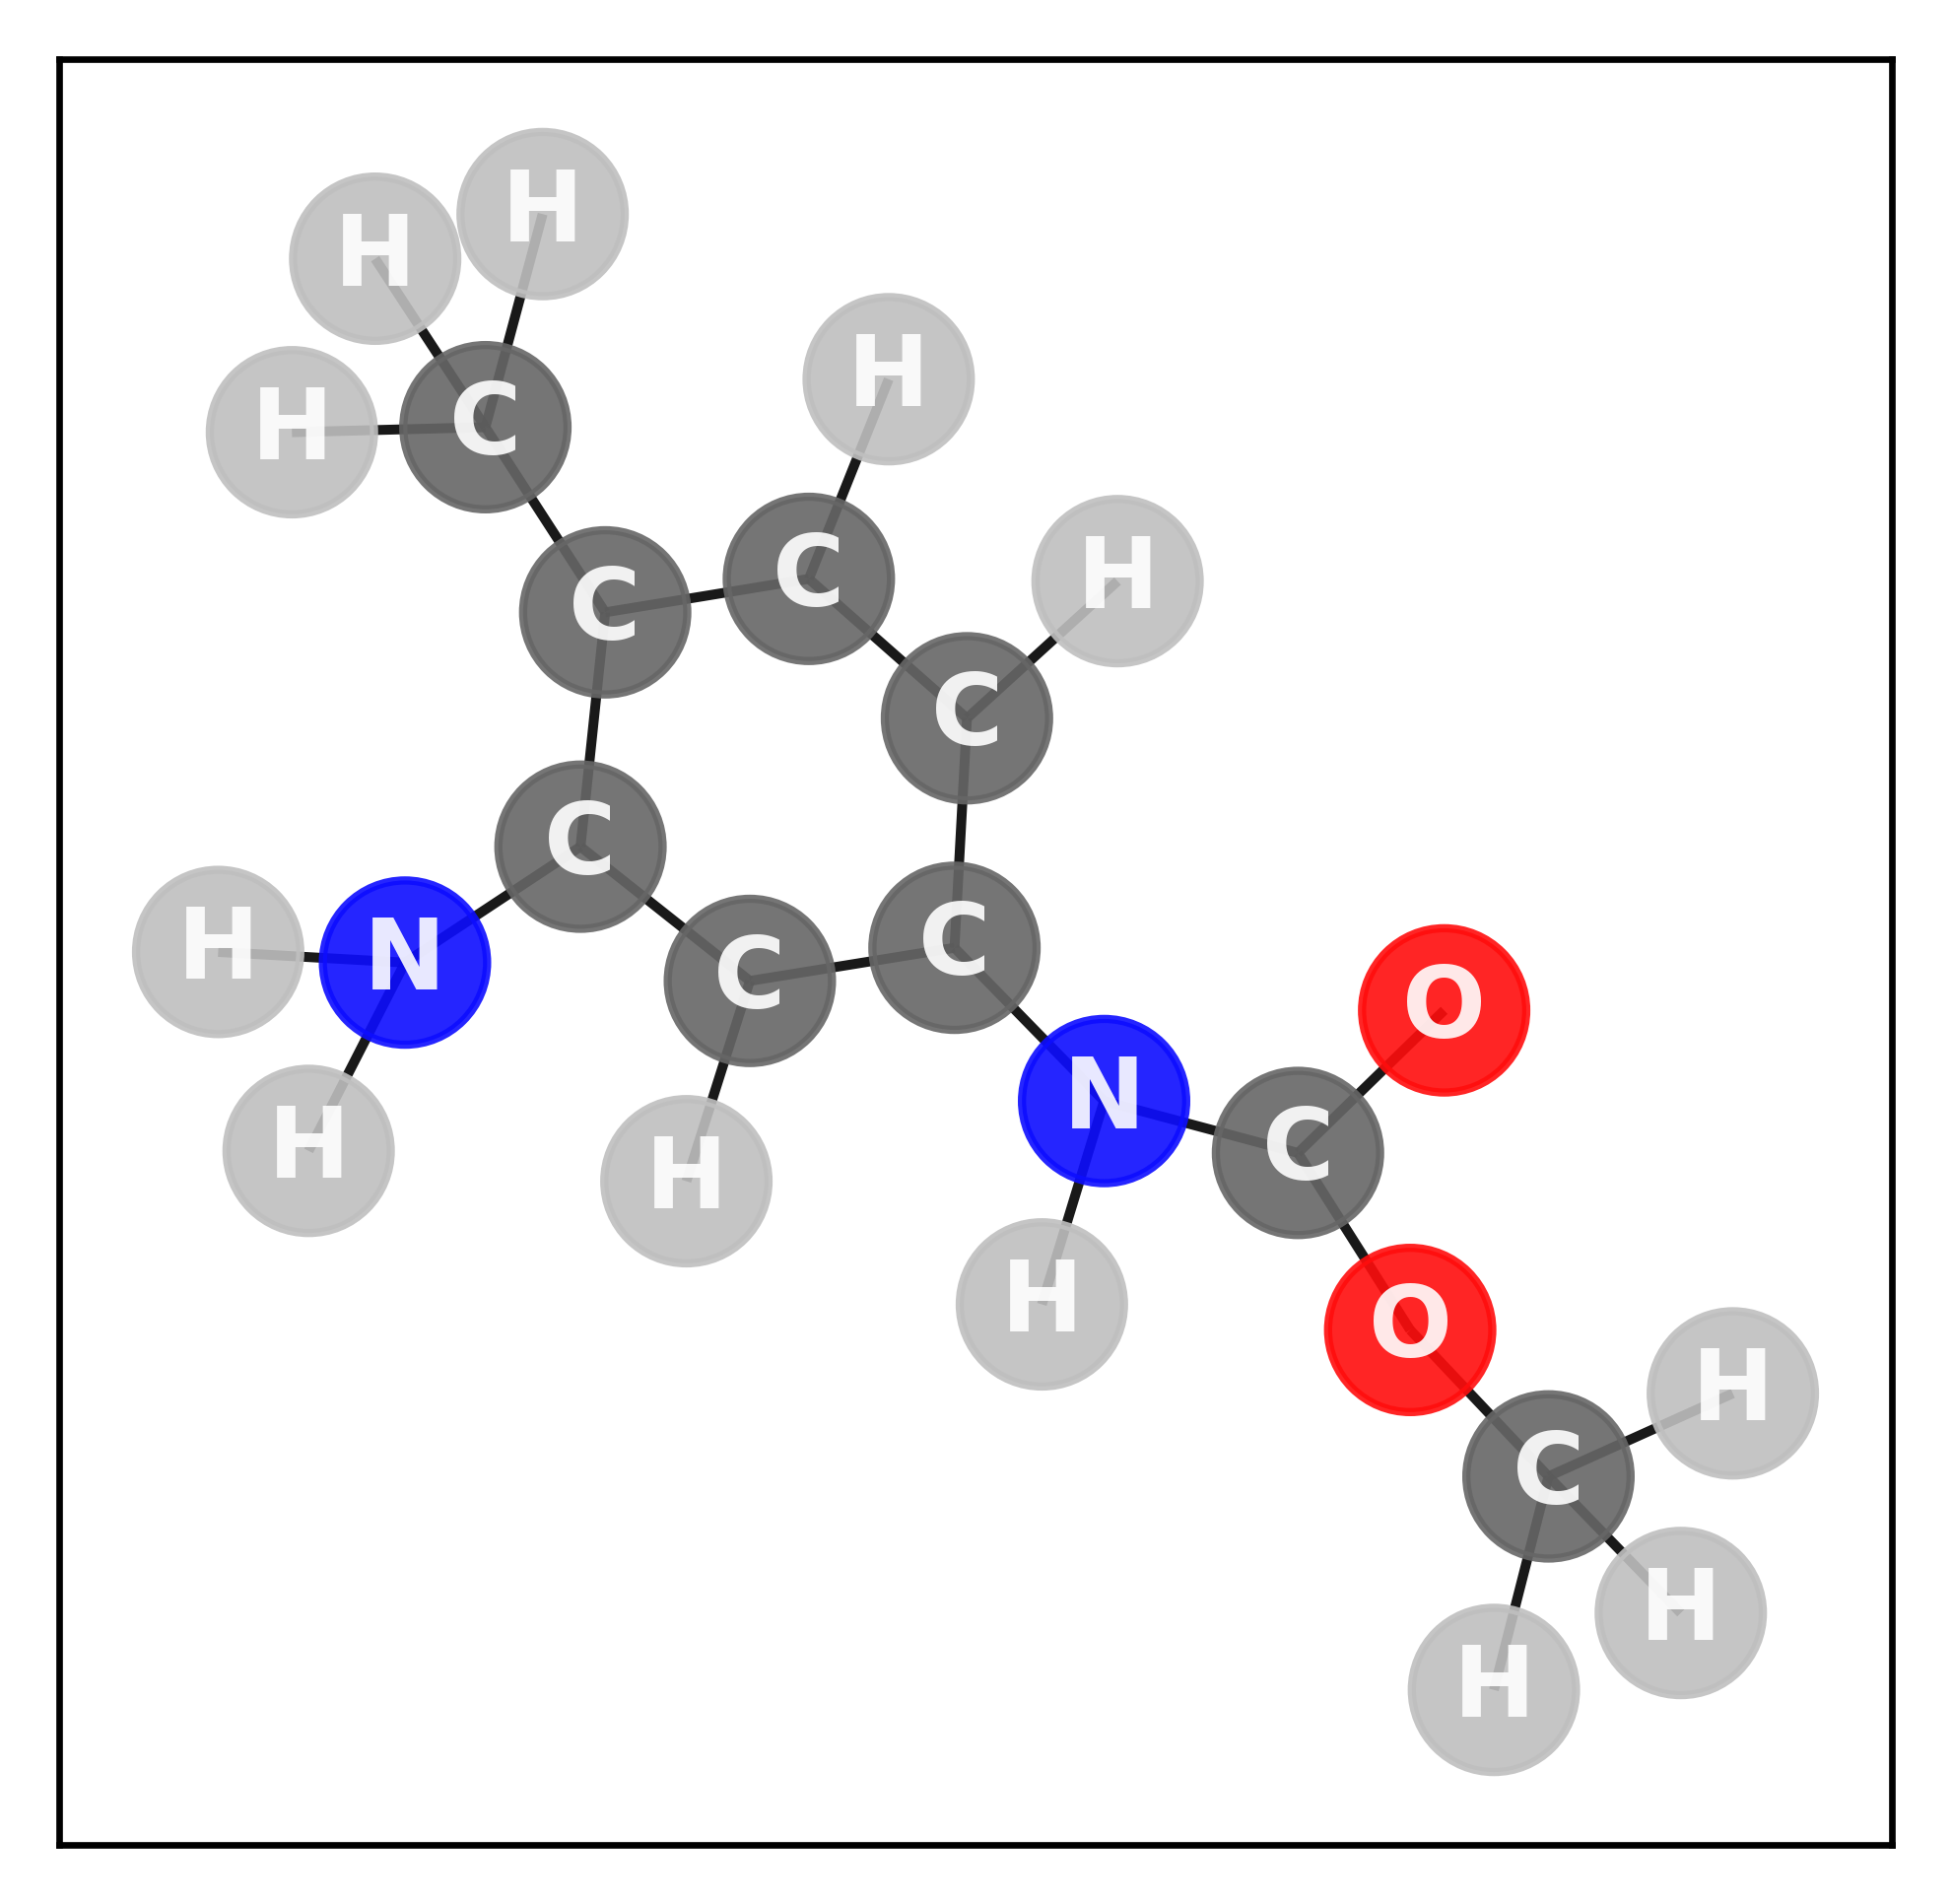

System: mol_17
GNN energy = -157.89 eV 
VASP energy = -156.61705379 eV
Prediction error = 1.27 eV
-----------------------------------


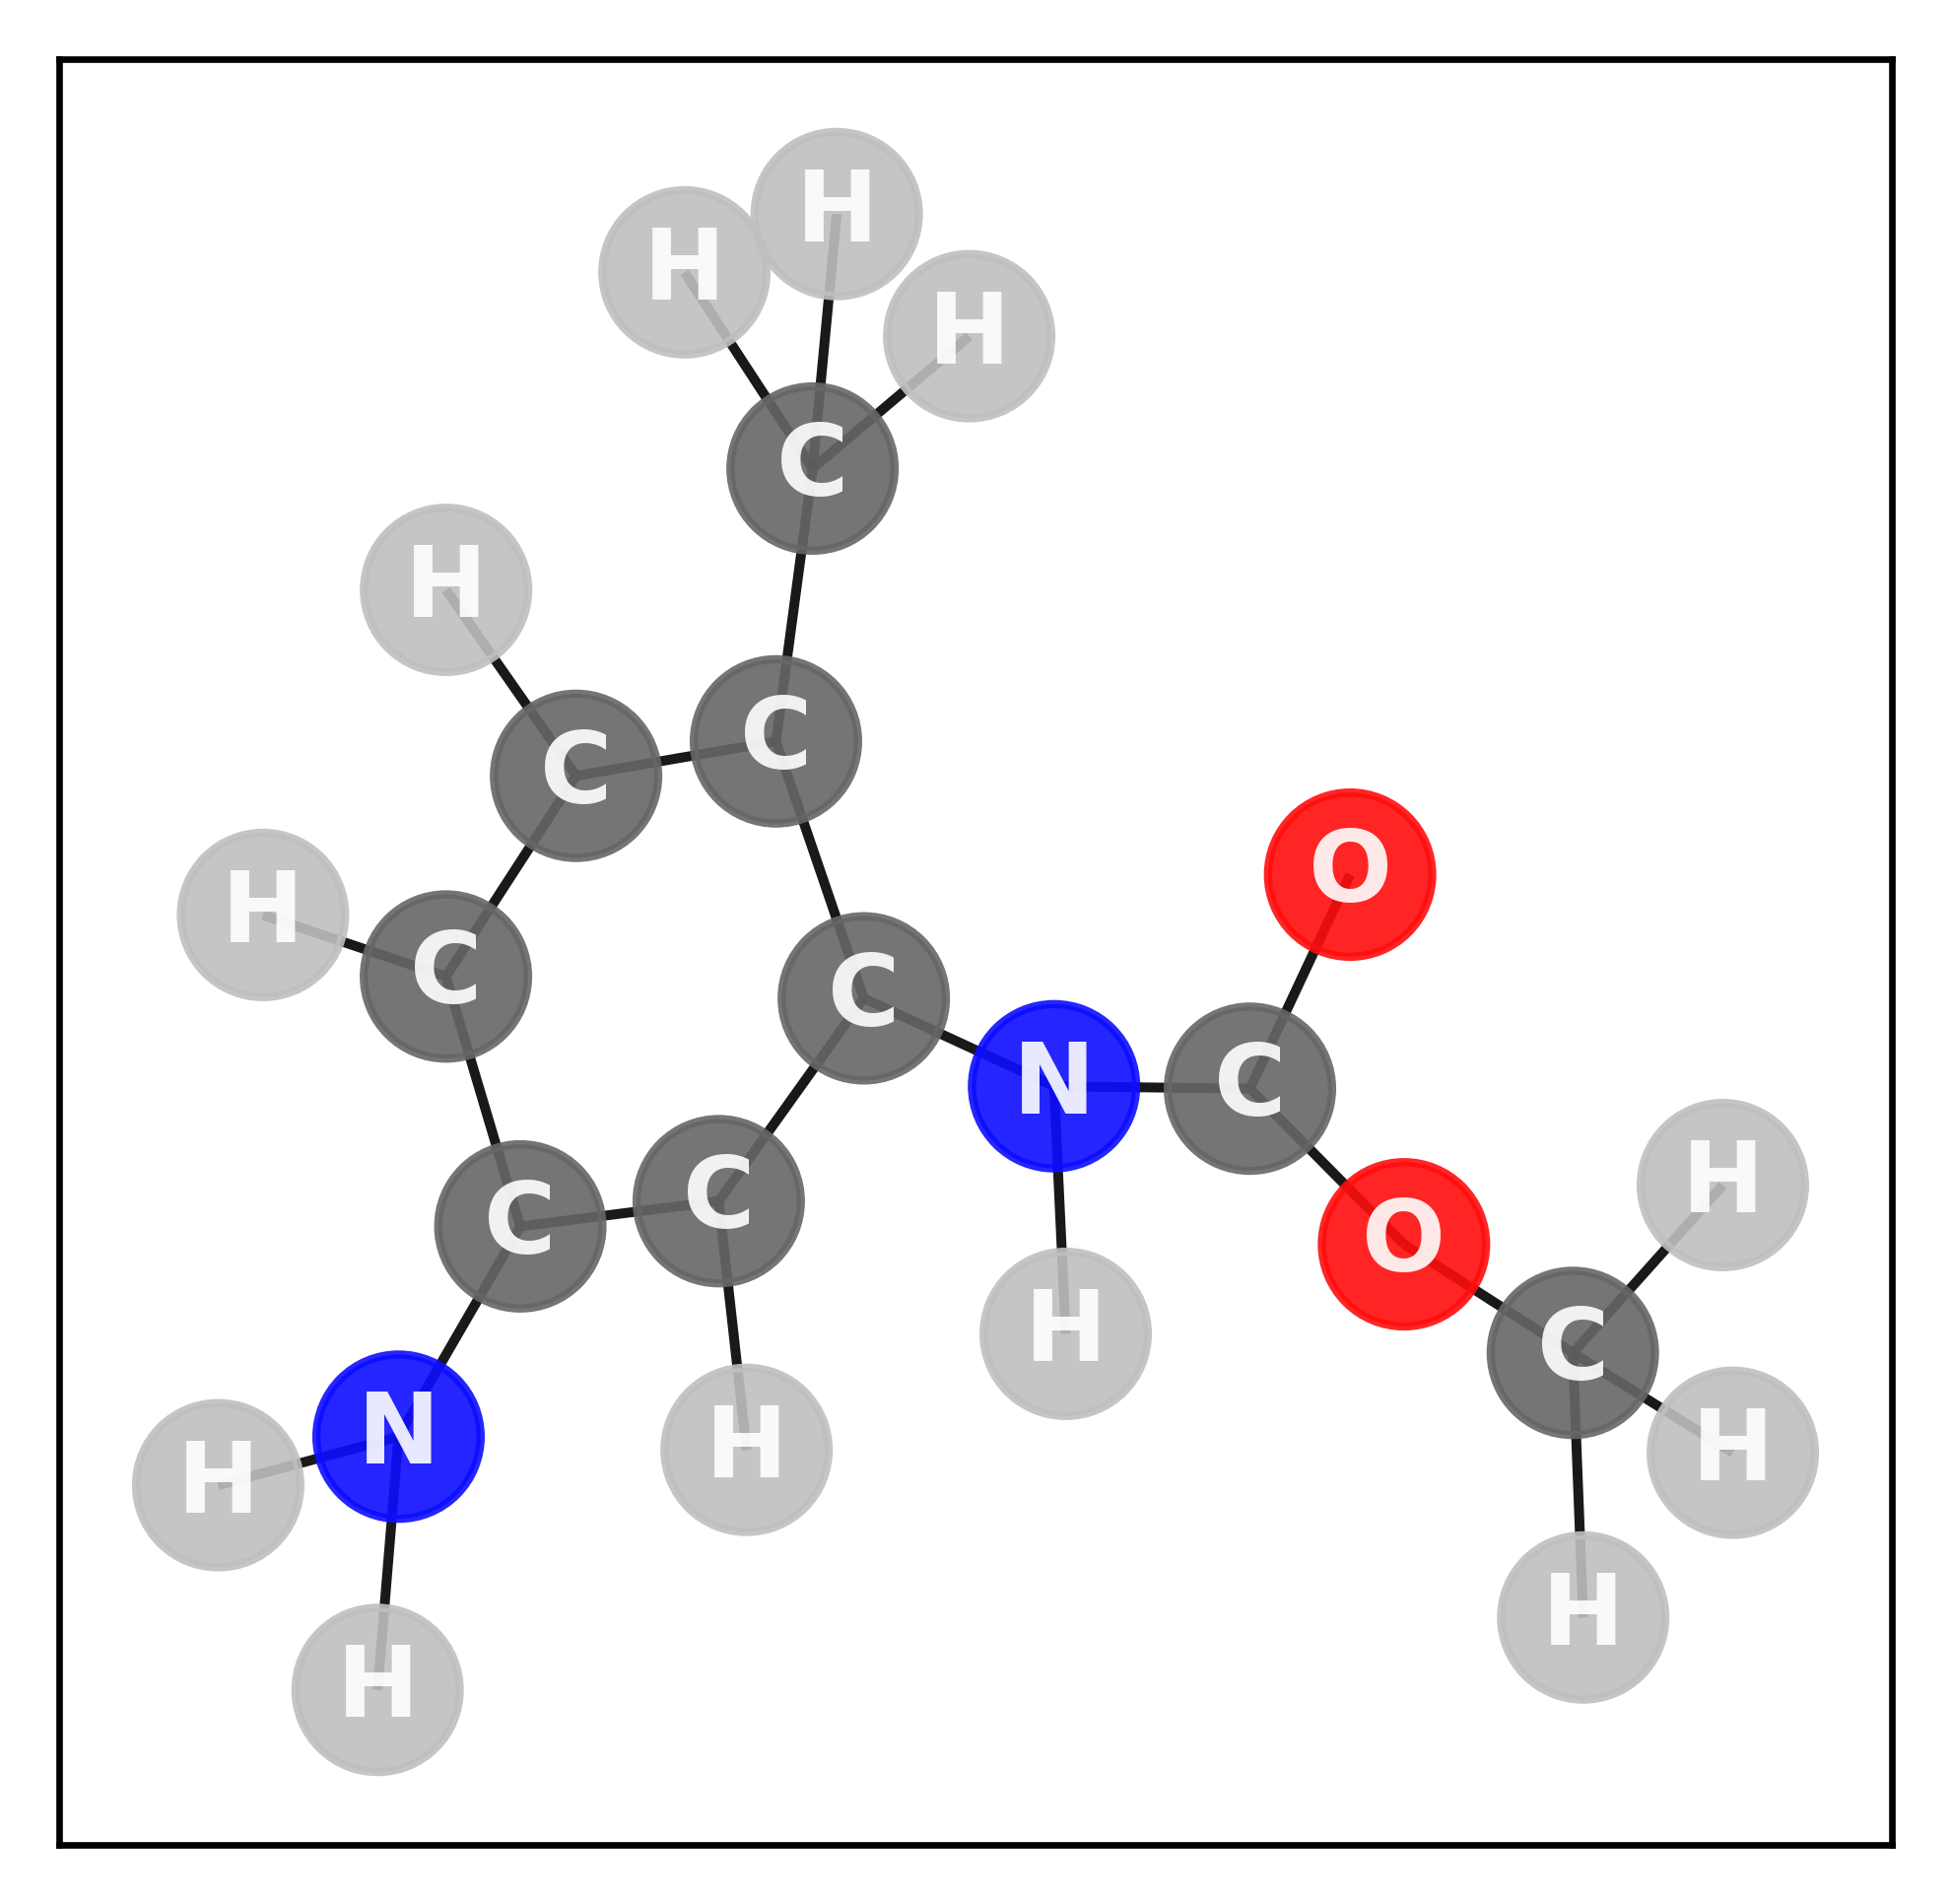

System: mol_18
GNN energy = -157.89 eV 
VASP energy = -156.57552837 eV
Prediction error = 1.32 eV
-----------------------------------


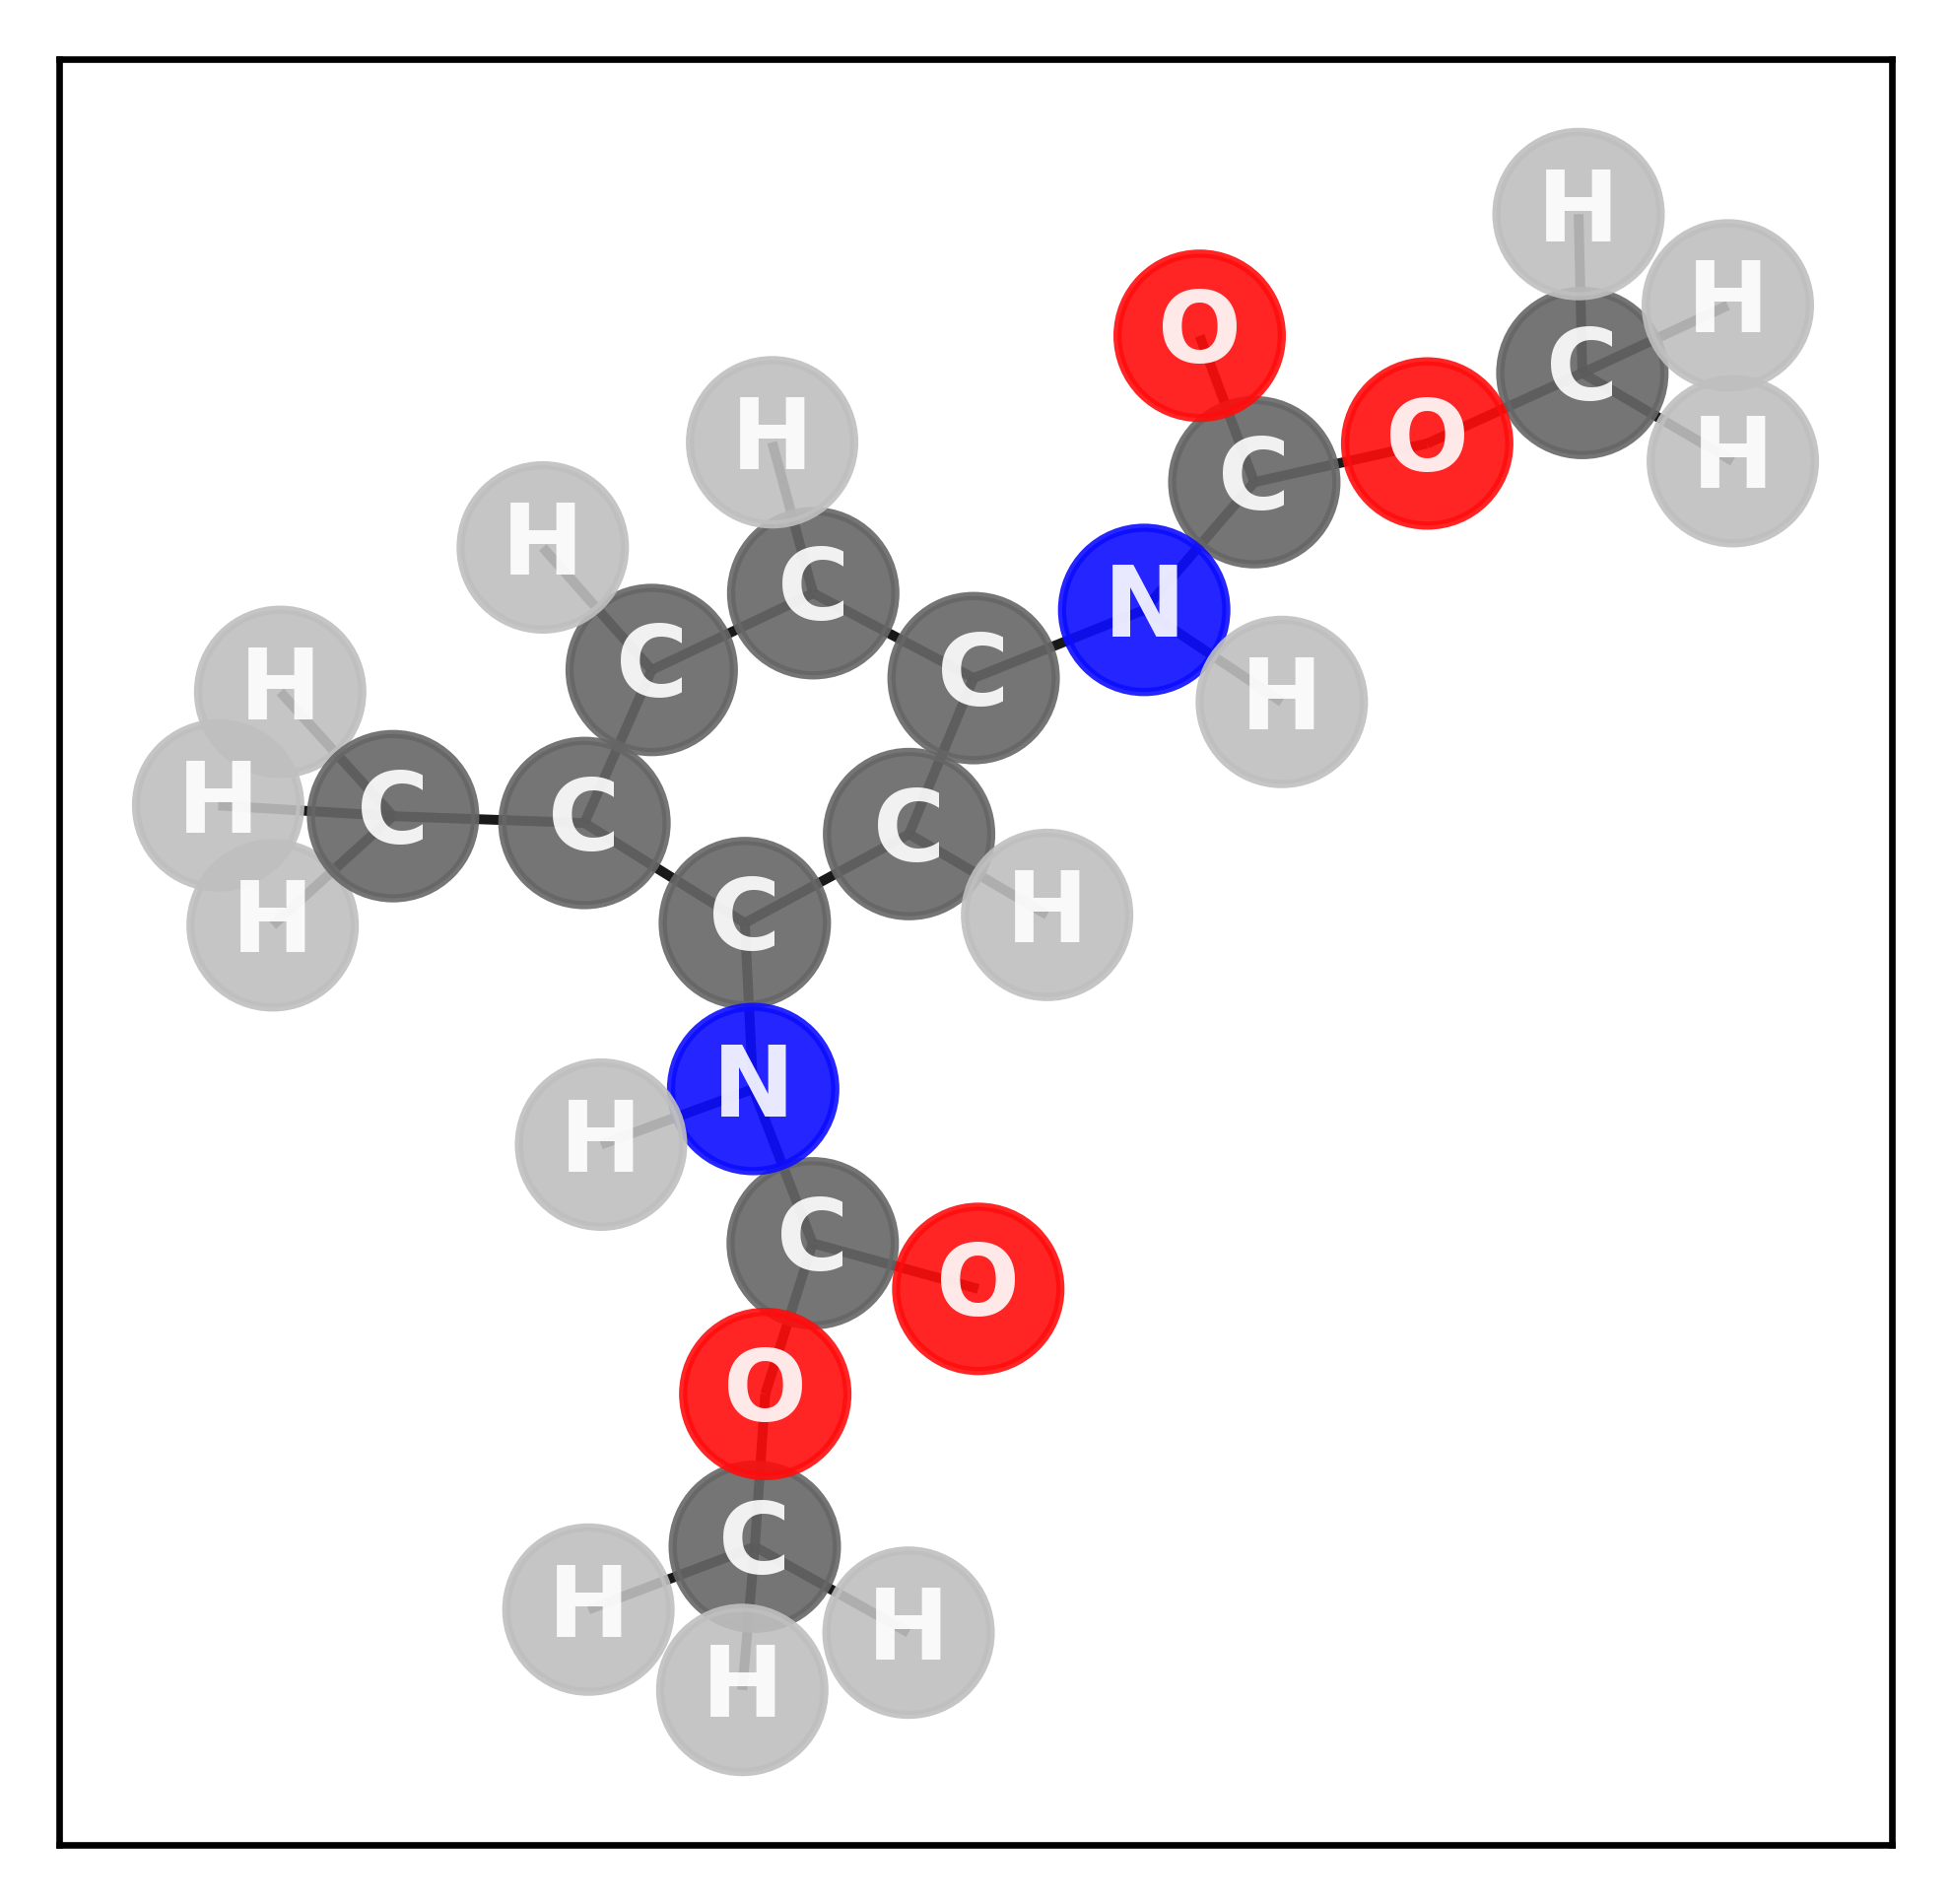

System: mol_19
GNN energy = -195.41 eV 
VASP energy = -195.85739787 eV
Prediction error = -0.45 eV
-----------------------------------


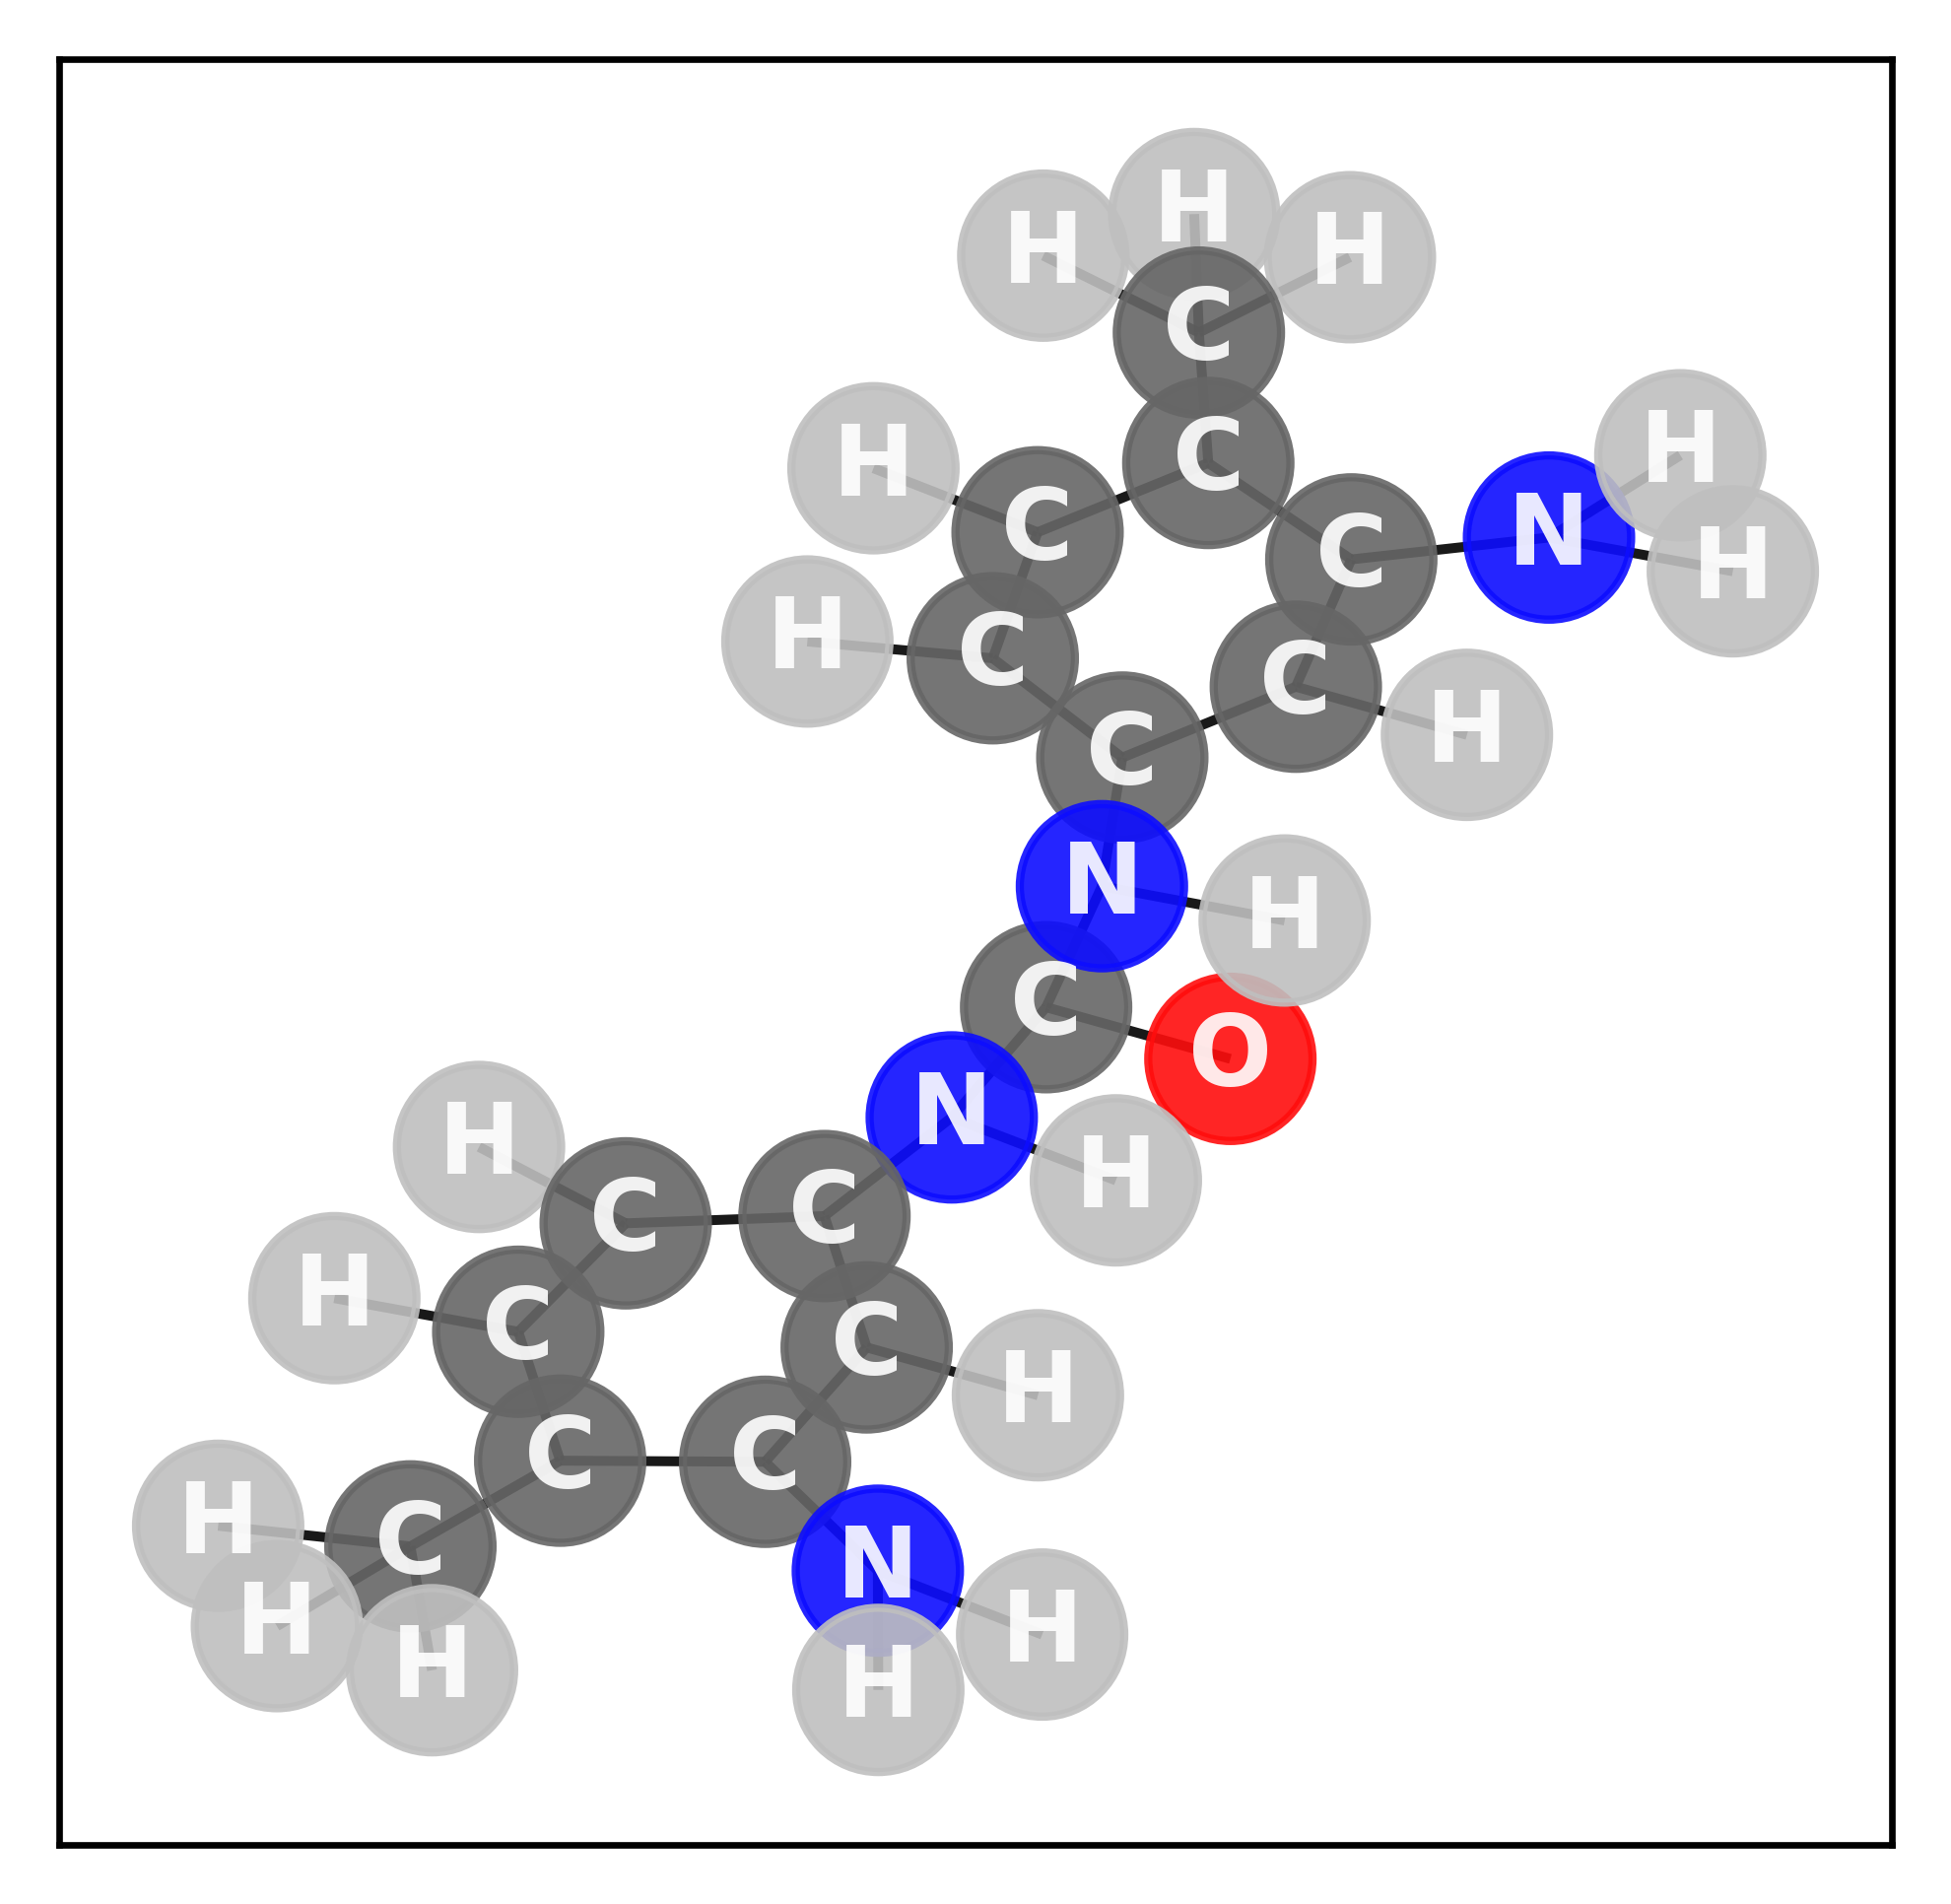

System: mol_41
GNN energy = -239.22 eV 
VASP energy = -243.47832296 eV
Prediction error = -4.26 eV
----------POLYURETHANES-----------
MAE = 1.64 eV = 37.65 kcal/mol
MAE/atom = 0.05 eV/atom = 1.18 kcal/mol
----------------------------------


In [1]:
from pymatgen.io.vasp import Outcar
from pyRDTP.geomio import file_to_mol
from functions import *
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch
from graph_tools import plotter
import matplotlib.pyplot as plt
from classes import *
from nets import *

# Load trained GNN model (architecture + parameters)
MODEL_NAME = "SN1_X"
MODEL_PATH = "./Models/{}/".format(MODEL_NAME)
file = open("{}performance.txt".format(MODEL_PATH))
lines = file.readlines()
mean_tv = float(lines[3].split()[-2])
std_tv = float(lines[4].split()[-2])
model = SantyxNet(dim=128, node_features=node_features)
model.load_state_dict(torch.load("{}GNN.pth".format(MODEL_PATH)))
model.eval()

# Test new samples previously optmized with VASP to check extrapolation performance
au_energy = Outcar("./Extrapolation/Polyurethanes/au-sur/OUTCAR").final_energy * 4
cu_energy = Outcar("./Extrapolation/Polyurethanes/cu-sur/OUTCAR").final_energy
sur = ["au", "cu"] #ag or au
pu = ["mol_16", "mol_17", "mol_18", "mol_19", "mol_41"]
sur_energy = {"au": au_energy, "cu": cu_energy}
error = np.zeros((len(pu)*(1 + len(sur)), 1))
error_per_atom = np.zeros((len(pu)*(1 + len(sur)), 1))
abs_error = np.zeros((len(pu)*(1 + len(sur)), 1))
counter = 0
for metal in sur: # Adsorption configurations
    for molecule in pu:
        calc = "{}-{}".format(metal, molecule)
        system = "./Extrapolation/Polyurethanes/{}/CONTCAR".format(calc)
        s = Outcar("./Extrapolation/Polyurethanes/{}/OUTCAR".format(calc))
        s = s.final_energy
        mol = file_to_mol(system, 'contcar', bulk=False)
        mol = mol_to_ensemble(mol, VORONOI_TOLERANCE, CORDERO)
        nx_graph = ensemble_to_graph(mol)
        elem = list(nx_graph[1][0])
        source = list(nx_graph[1][1][0])
        target = list(nx_graph[1][1][1])
        elem_array = np.array(elem).reshape(-1, 1)
        elem_enc = encoder.transform(elem_array).toarray()
        edge_index = torch.tensor([source, target], dtype=torch.long)
        x = torch.tensor(elem_enc, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index)
        DL = DataLoader([data], batch_size=1, shuffle=False)   
        for batch in DL:
            energy = model(batch).item() * std_tv + mean_tv
        print("-----------------------------------")
        plotter(data)
        plt.show()
        print("System: {}-{}".format(metal, molecule))
        print("GNN energy = {:.2f} eV ".format(energy))
        print("VASP energy = {} eV".format(s - sur_energy[metal]))
        print("Prediction error = {:.2f} eV".format(s - sur_energy[metal] - energy))
        error[counter] = s - sur_energy[metal] - energy
        abs_error[counter] = abs(error[counter])
        error_per_atom[counter] = abs_error[counter] / data.num_nodes
        counter += 1
for molecule in pu:  # gas phase molecules
    calc = "{}".format(molecule)
    system = "./Extrapolation/Polyurethanes/{}/CONTCAR".format(calc)
    s = Outcar("./Extrapolation/Polyurethanes/{}/OUTCAR".format(calc))
    s = s.final_energy
    mol = file_to_mol(system, 'contcar', bulk=False)
    mol = mol_to_ensemble(mol, VORONOI_TOLERANCE, CORDERO)
    nx_graph = ensemble_to_graph(mol)
    elem = list(nx_graph[1][0])
    source = list(nx_graph[1][1][0])
    target = list(nx_graph[1][1][1])
    elem_array = np.array(elem).reshape(-1, 1)
    elem_enc = encoder.transform(elem_array).toarray()
    edge_index = torch.tensor([source, target], dtype=torch.long)
    x = torch.tensor(elem_enc, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    DL = DataLoader([data], batch_size=1, shuffle=False)   
    for batch in DL:
        energy = model(batch).item() * std_tv + mean_tv
    print("-----------------------------------")
    plotter(data)
    plt.show()
    print("System: {}".format(molecule))
    print("GNN energy = {:.2f} eV ".format(energy))
    print("VASP energy = {} eV".format(s))
    print("Prediction error = {:.2f} eV".format(s - energy))
    error[counter] = s - energy
    abs_error[counter] = abs(error[counter])
    error_per_atom[counter] = abs_error[counter] / data.num_nodes
    counter += 1
print("----------POLYURETHANES-----------")
print("MAE = {:.2f} eV = {:.2f} kcal/mol".format(np.mean(abs_error), np.mean(abs_error) * 23))
print("MAE/atom = {:.2f} eV/atom = {:.2f} kcal/mol".format(np.mean(error_per_atom), np.mean(error_per_atom) * 23))
print("----------------------------------")